# Bohn Jour
___

In [1]:
from __future__ import unicode_literals
from scipy.stats import linregress
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import datetime
import common.chat
import common.live
import common.videos

In [2]:
#config
reload(sys)
sys.setdefaultencoding('utf-8')
pd.set_option('display.max_columns', None)
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
CHAT_DATA_DIRECTORY = '/home/marcel/rbtv/rbtvdata/chat'
LIVE_DATA_DIRECTORY = '/home/marcel/rbtv/rbtvdata/live'
VIDEO_DATA_DIRECTORY = '/home/marcel/rbtv/rbtvdata/video'

#dates
bohnJour1Date = datetime.date(2015, 8, 1)
bohnJour2Date = datetime.date(2016, 6, 7)
youtubeAraDate = datetime.date(2016, 9, 1)

#colors
bohnJour1Color = '#66a1ff'
bohnJour2TwitchColor = '#ff6666'
bohnJour2YoutubeColor = '#ff8766'

#legend
bohnJour1Legend = mpatches.Patch(color=bohnJour1Color, label='Bohn Jour Staffel 1')
bohnJour2TwitchLegend = mpatches.Patch(color=bohnJour2TwitchColor, label='Bohn Jour Staffel 2 (Twitch)')
bohnJour2YoutubeLegend = mpatches.Patch(color=bohnJour2YoutubeColor, label='Bohn Jour Staffel 2 (Youtube)')
bohnJourLegend = [bohnJour1Legend, bohnJour2TwitchLegend, bohnJour2YoutubeLegend]

In [3]:
def aggColumn(data, column):
    dataSeason1 = data.loc[:bohnJour2Date]
    dataSeason2Twitch = data.loc[bohnJour2Date:youtubeAraDate]
    dataSeason2Youtube = data.loc[youtubeAraDate:]

    subDataSeason1 = dataSeason1[column].to_frame('Bohn Jour Staffel 1')
    subDataSeason2Twitch = dataSeason2Twitch[column].to_frame('Bohn Jour Staffel 2 (Twitch)')
    subDataSeason2Youtube = dataSeason2Youtube[column].to_frame('Bohn Jour Staffel 2 (Youtube)')

    return subDataSeason1.join(subDataSeason2Twitch, how='outer').join(subDataSeason2Youtube, how='outer')

In [4]:
#load live data
live = common.live.load(LIVE_DATA_DIRECTORY)

In [5]:
#load chat data
chat = common.chat.load(CHAT_DATA_DIRECTORY)

In [36]:
#load video data
videos, videosHosts, videosShows = common.videos.load(VIDEO_DATA_DIRECTORY)

## Auswertung
___

In [37]:
#filter by show
show = 'Bohn Jour'
videoIds = videosShows[videosShows['show'] == show].index.unique().tolist()
videosFiltered = videos[videos.index.isin(videoIds)]

#filter by date
videosFiltered = videosFiltered[videosFiltered['published'] > bohnJour1Date]

#create additional column
videosFiltered['part'] = videosFiltered['title'].str.extract('(\d)\/\d')
videosFiltered['ratings_total'] = videosFiltered['likeCount'] + videosFiltered['dislikeCount']
videosFiltered['ratings_ratio'] = 100 * videosFiltered['likeCount'] / videosFiltered['ratings_total']

#sort
videosFiltered = videosFiltered.sort_values('published')

#group videos by aired
videosGrouped = videosFiltered.groupby('aired', sort=False)

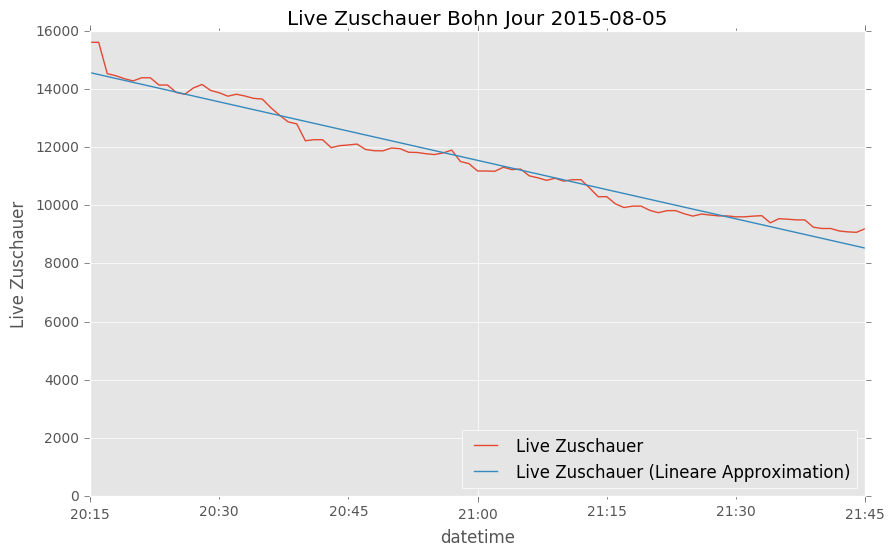

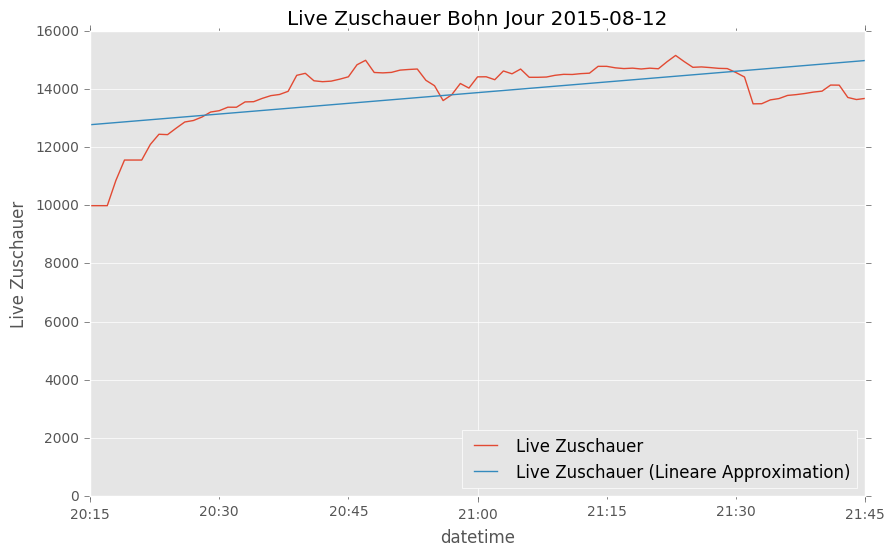

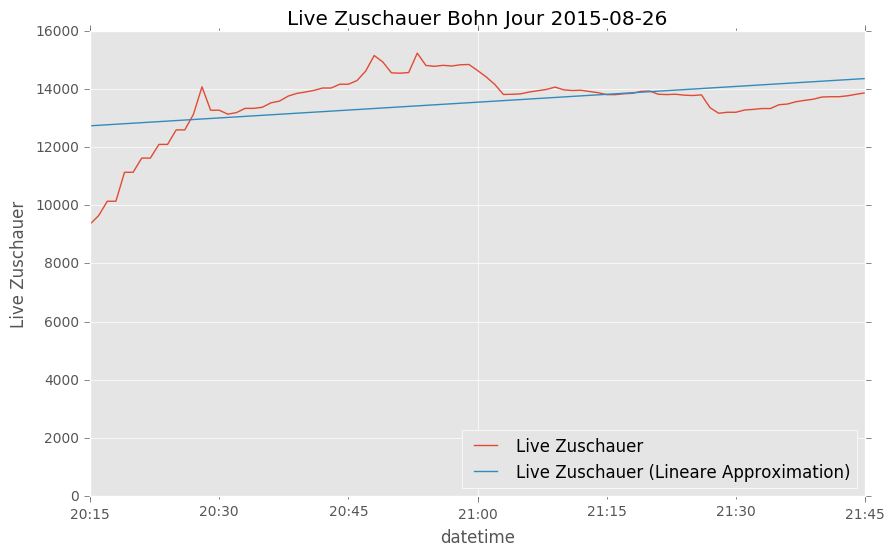

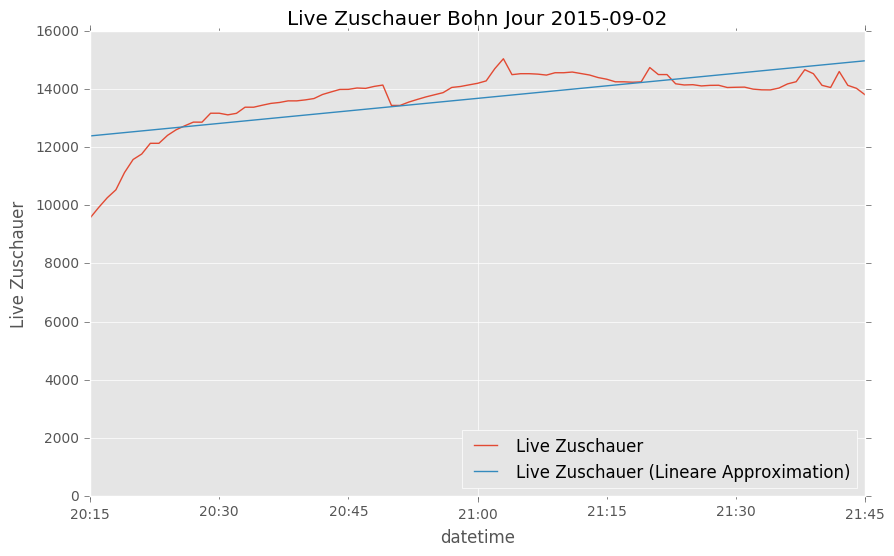

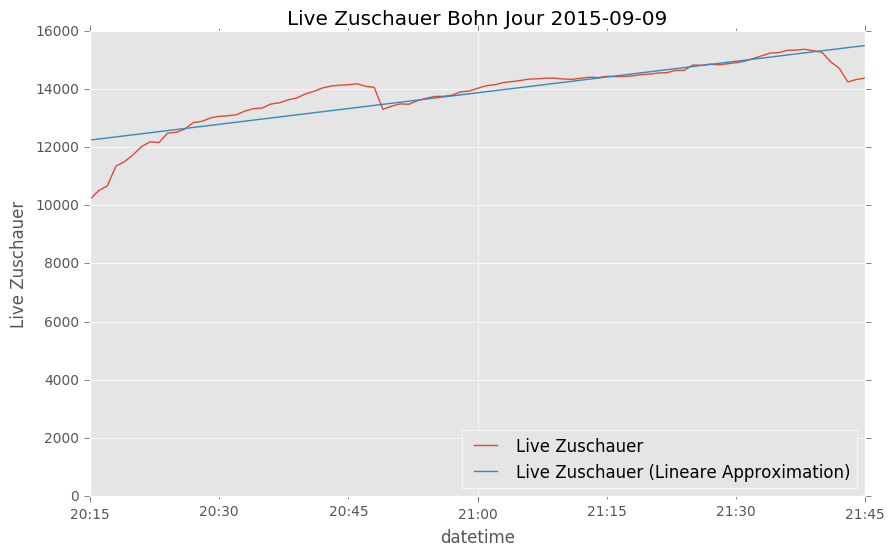

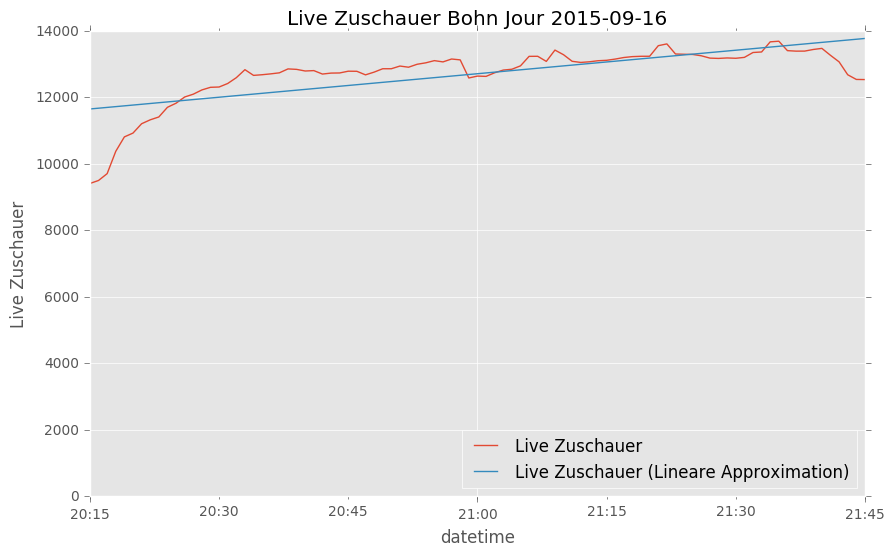

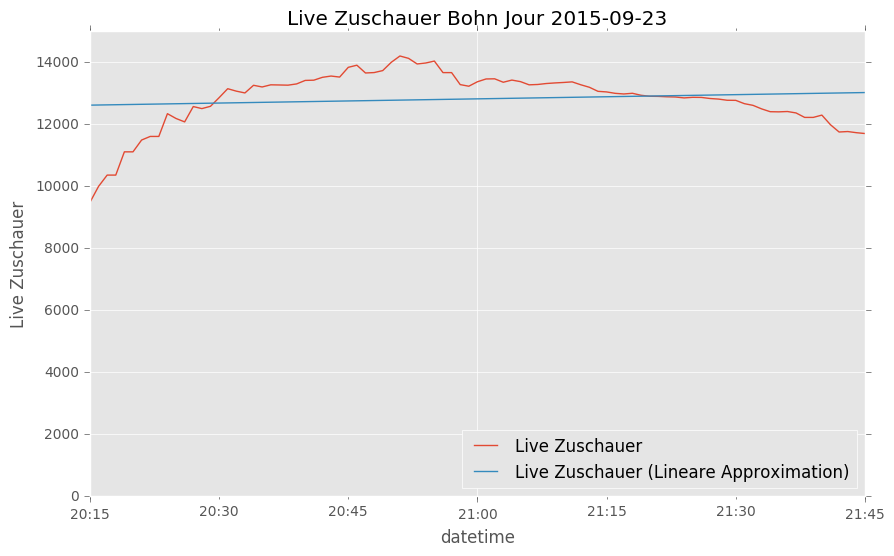

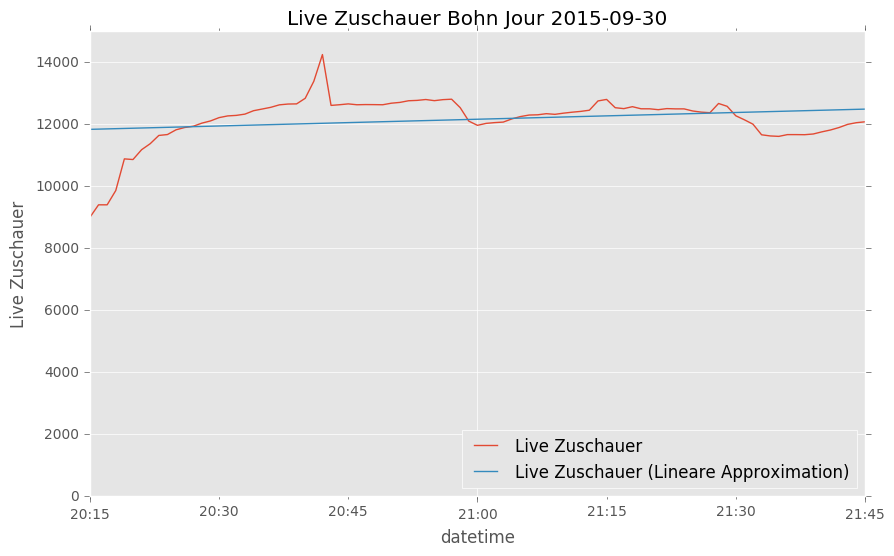

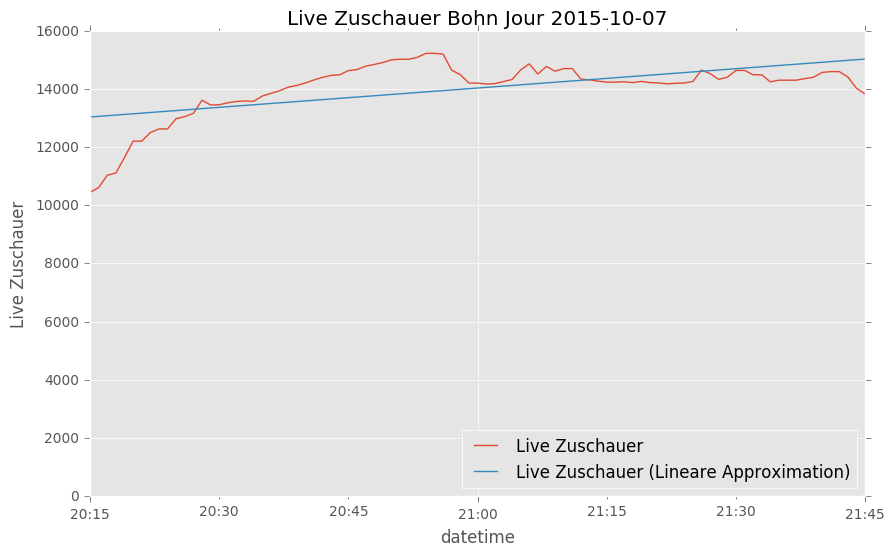

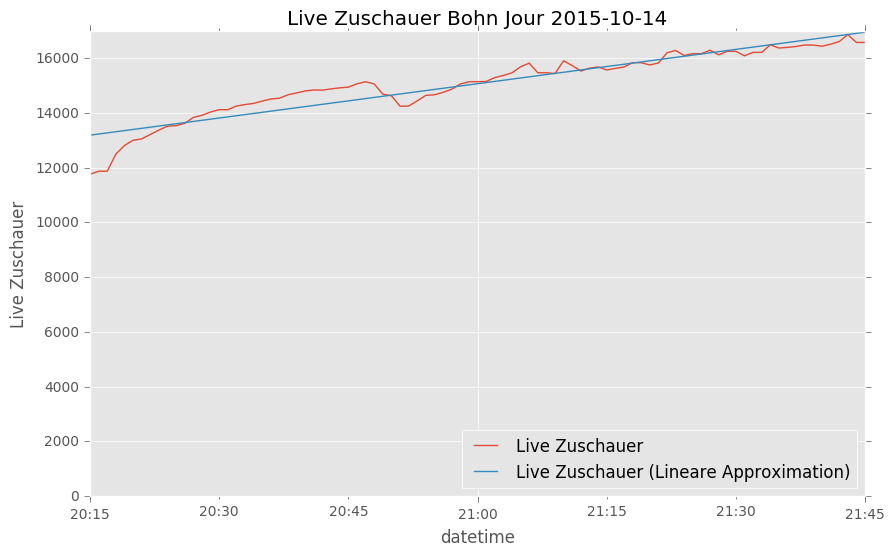

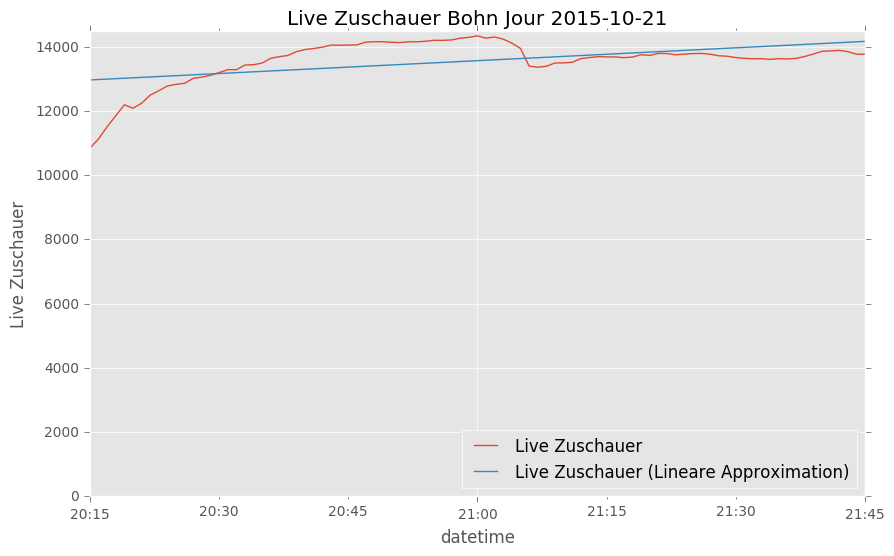

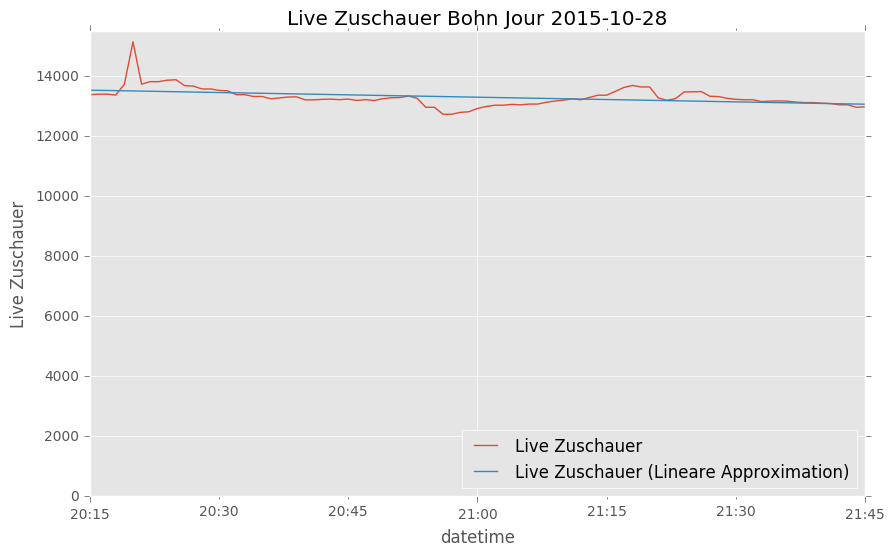

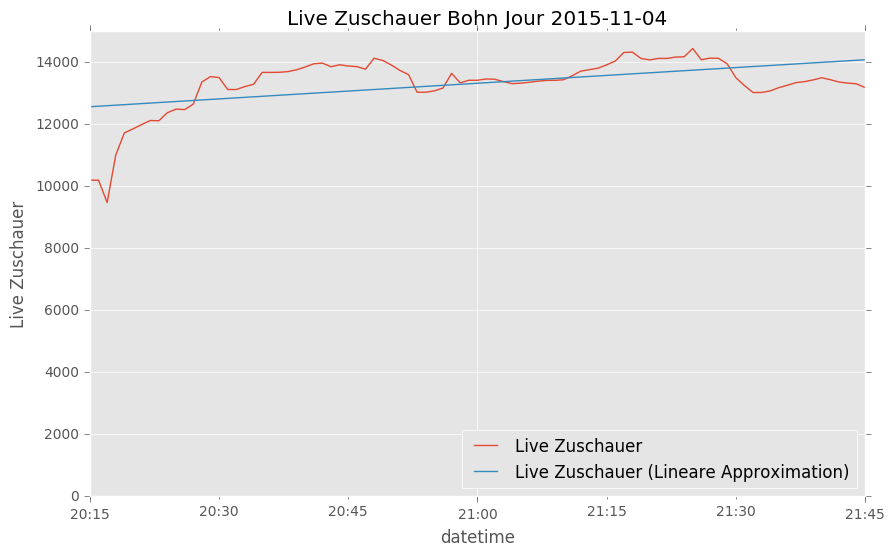

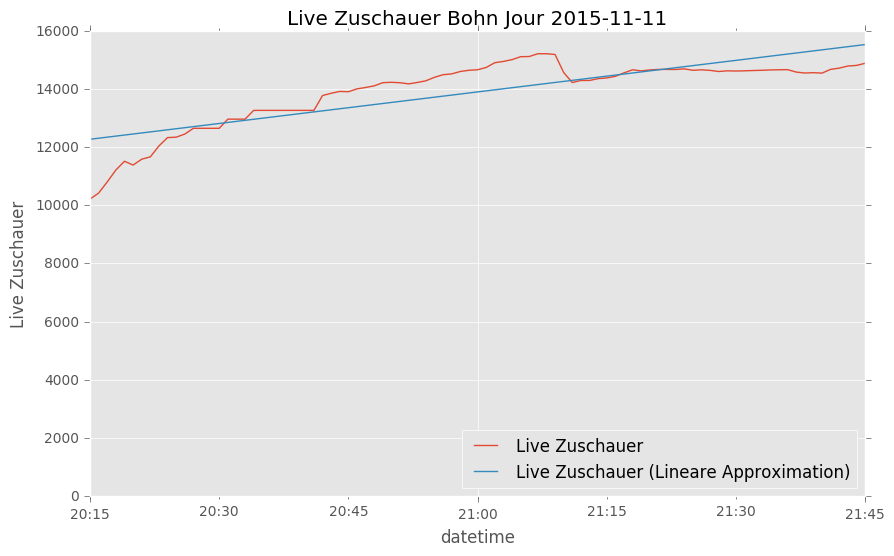

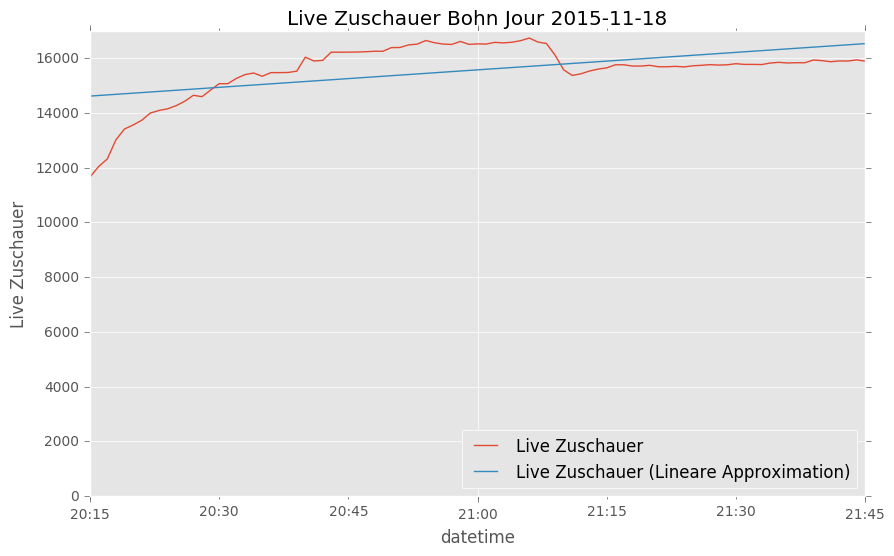

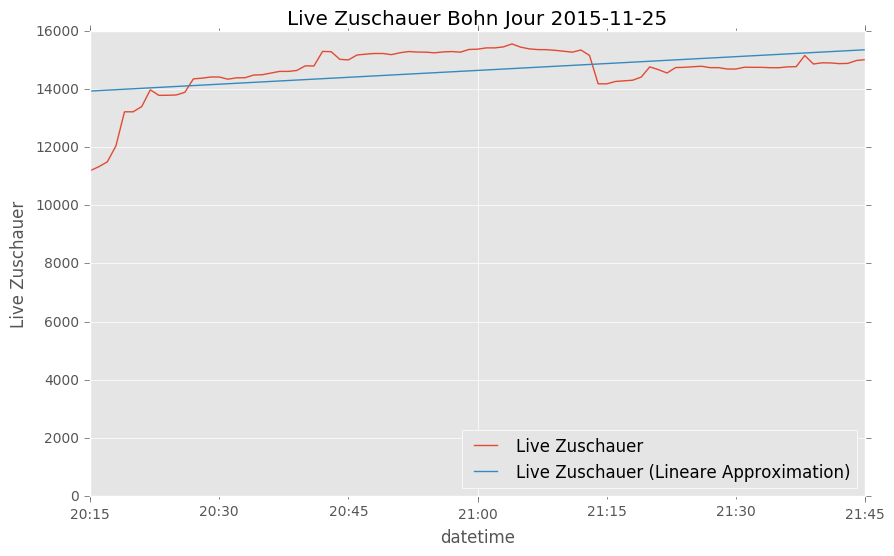

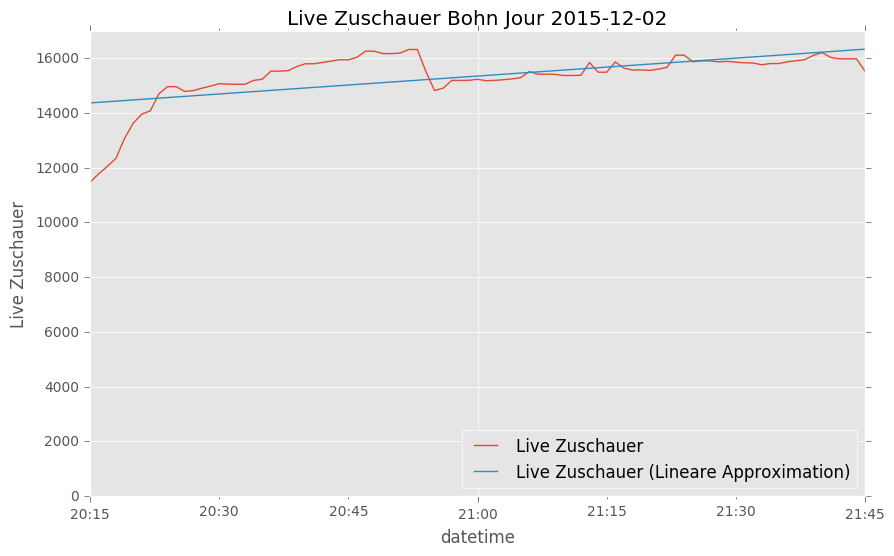

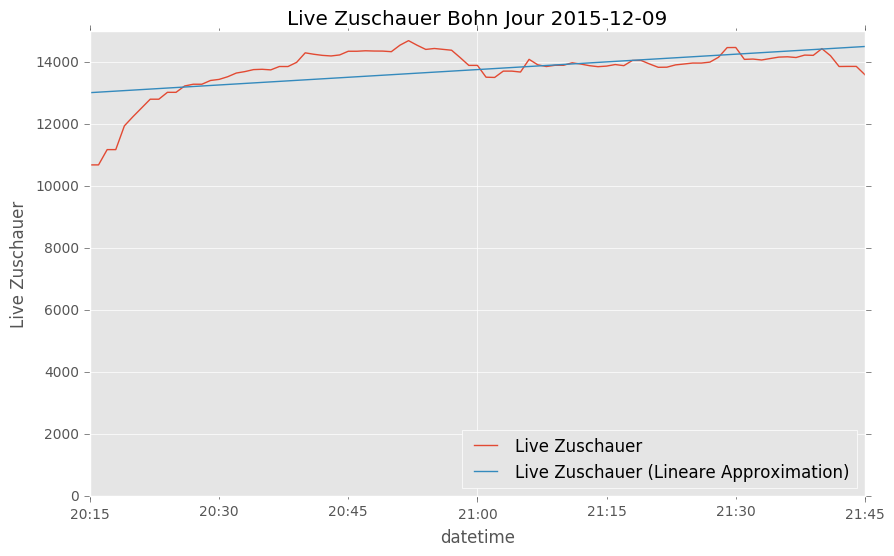

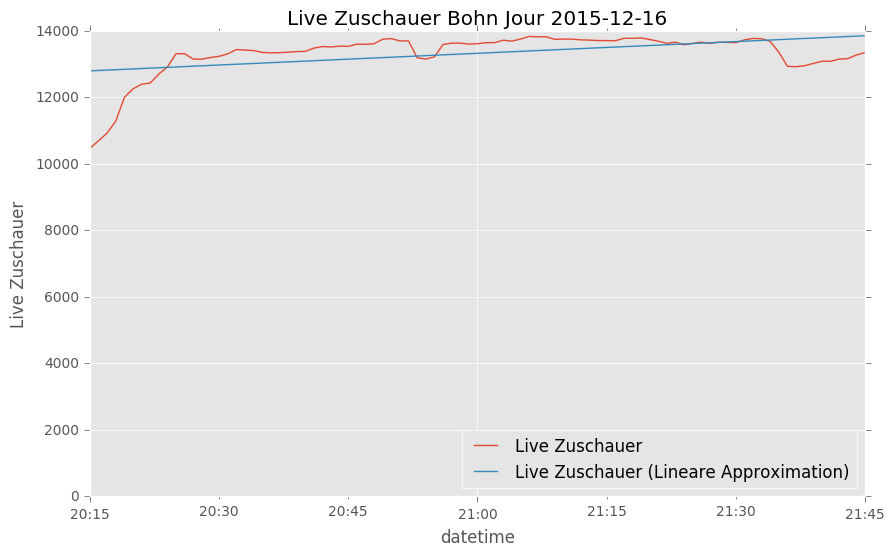

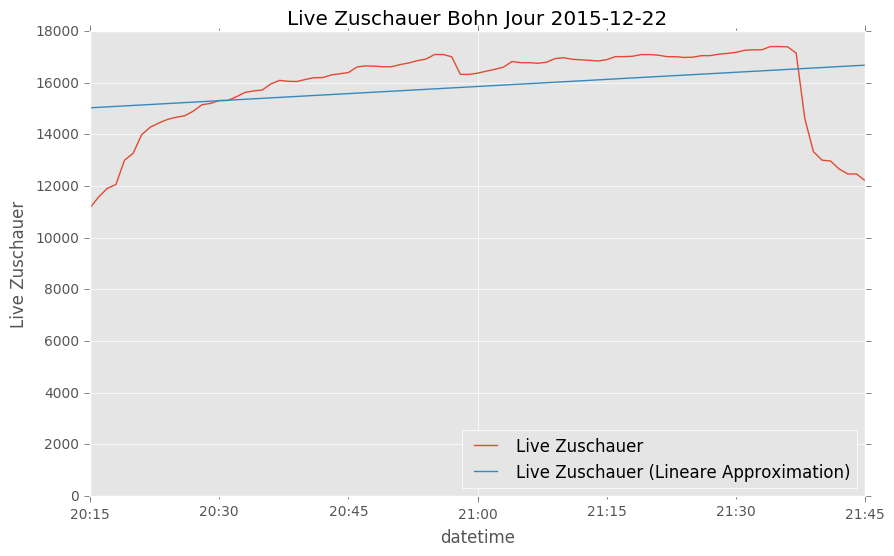

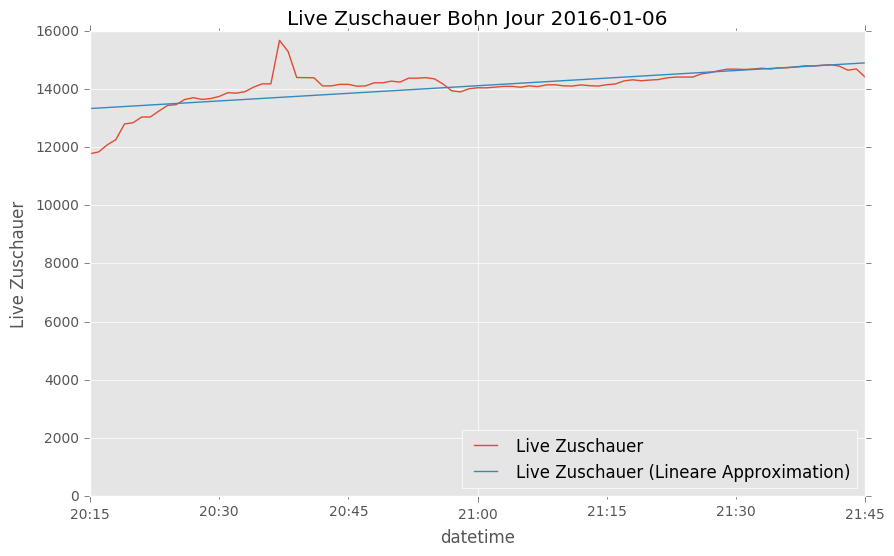

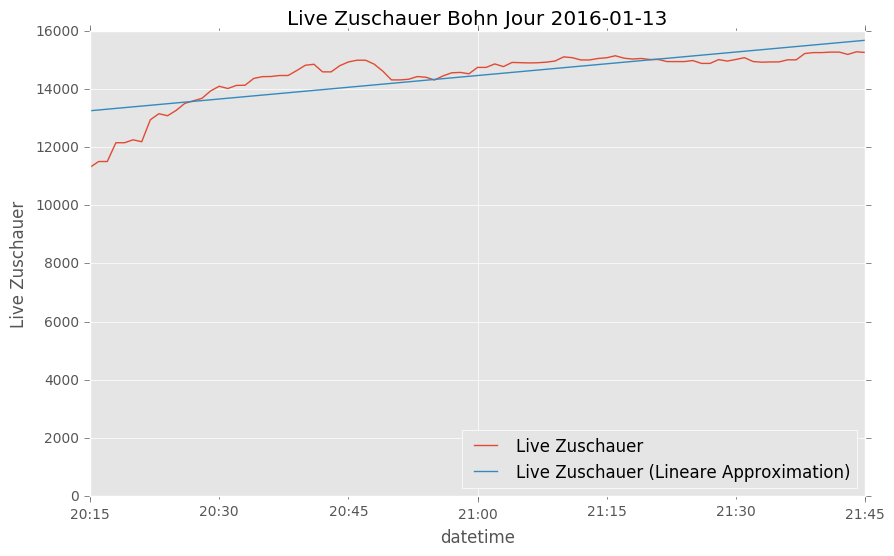

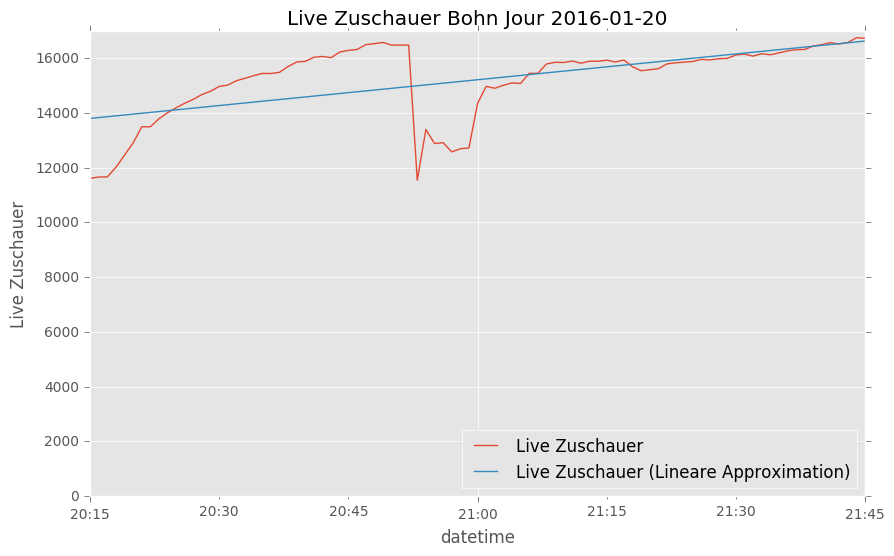

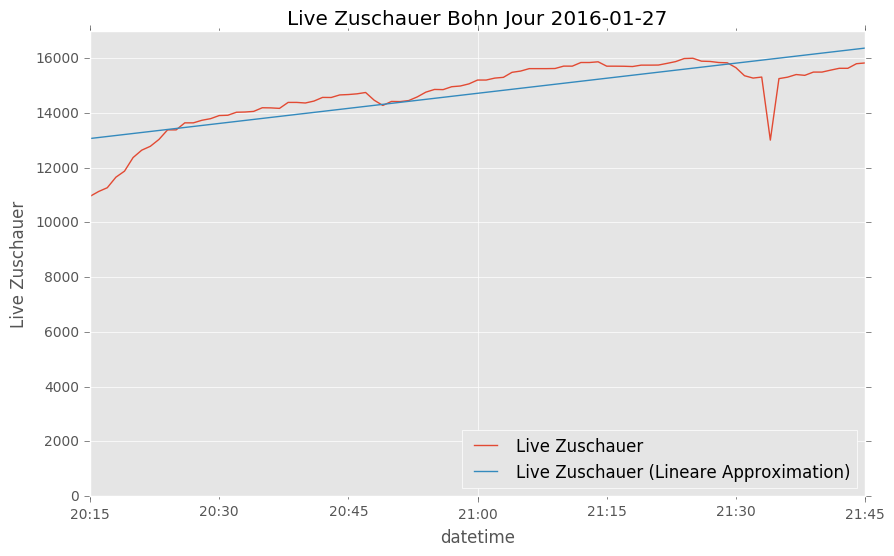

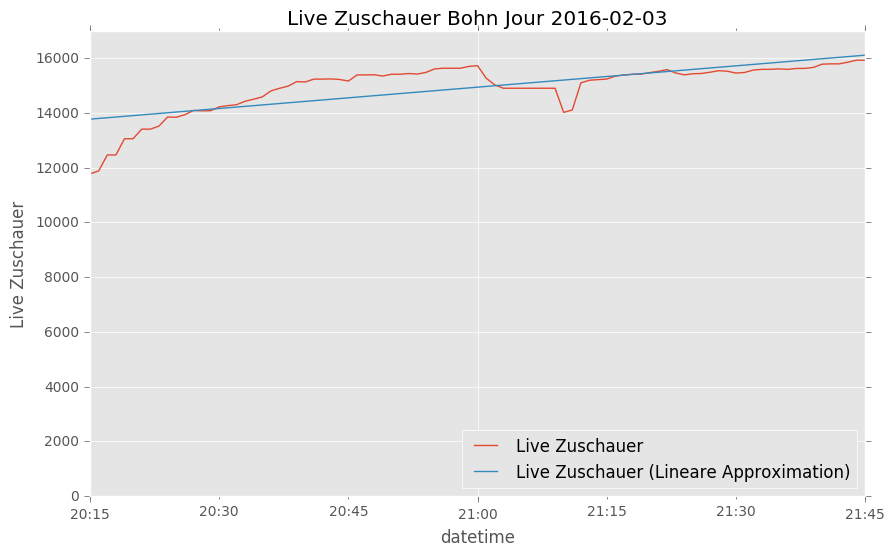

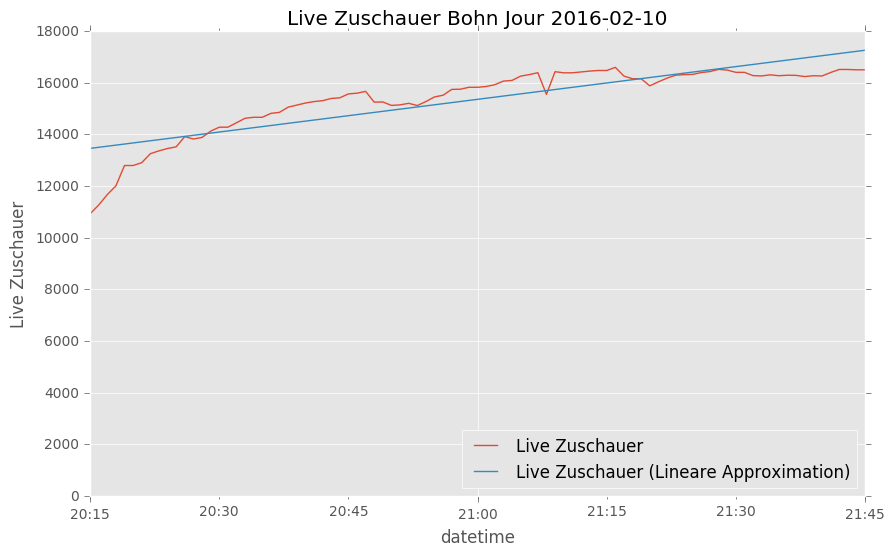

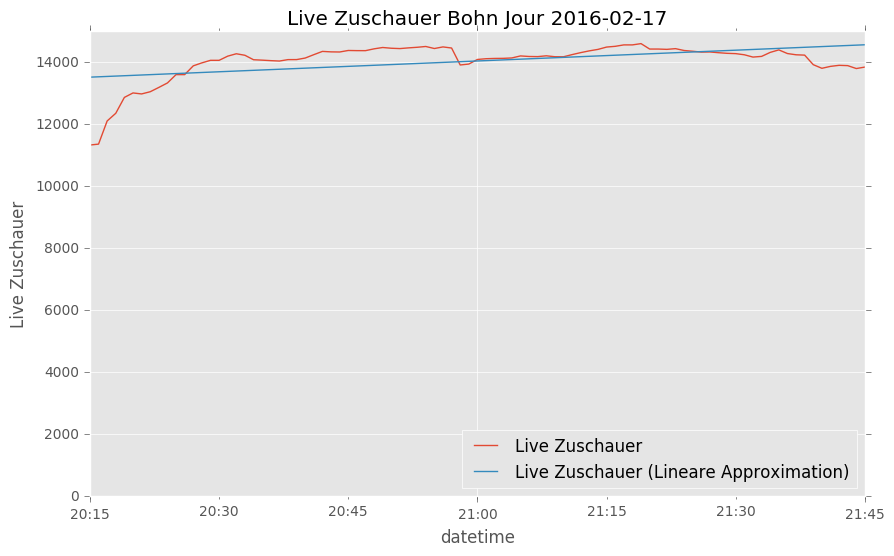

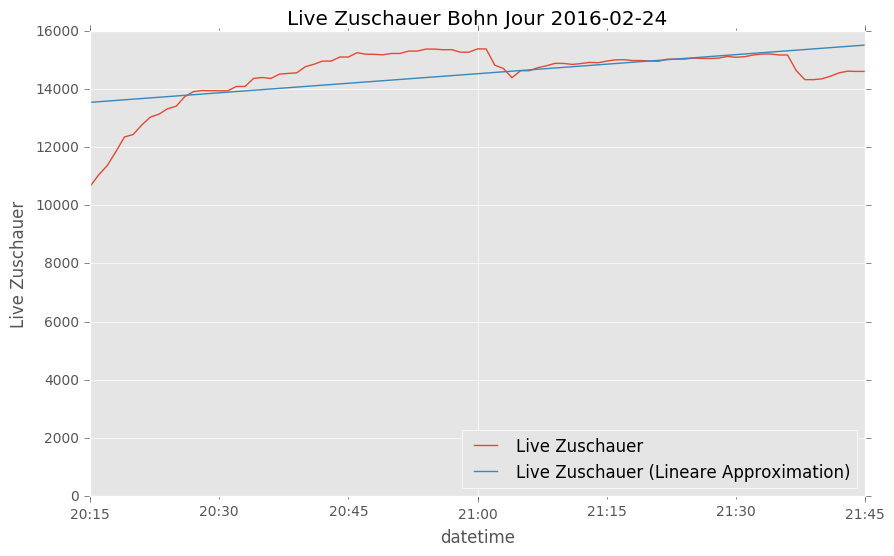

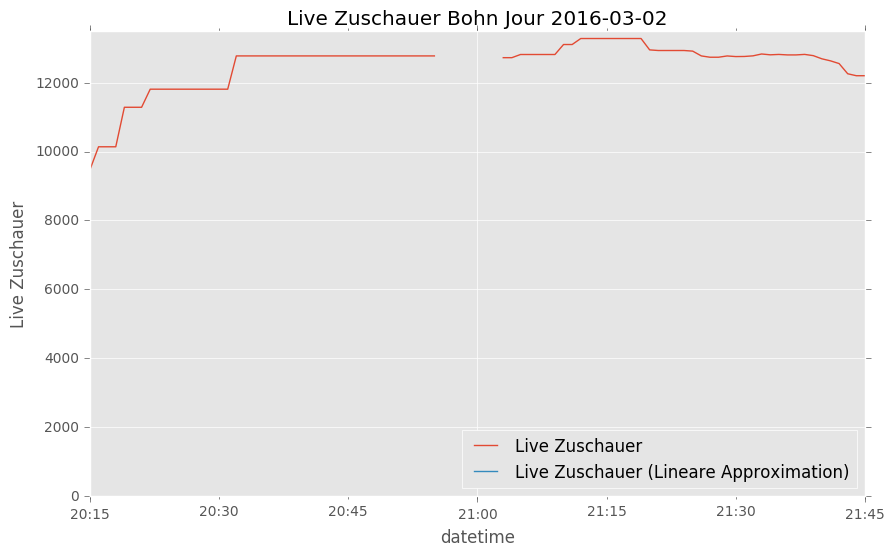

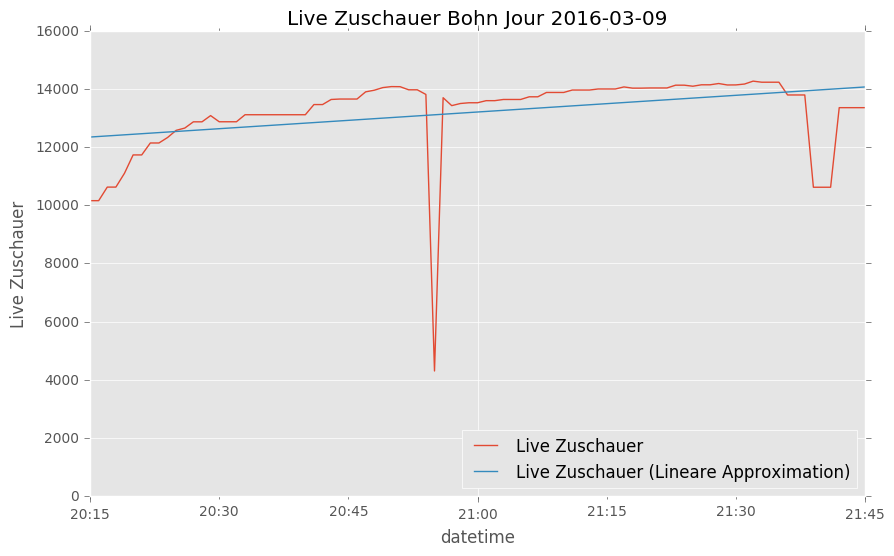

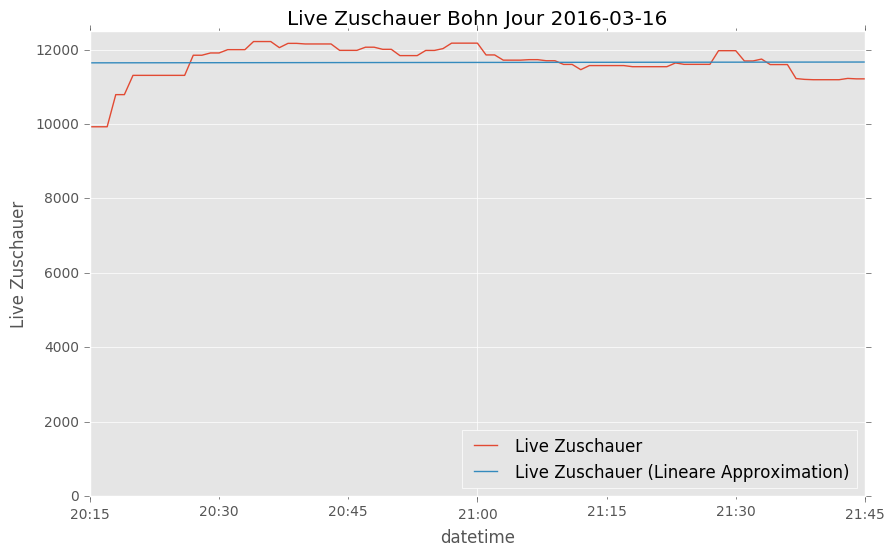

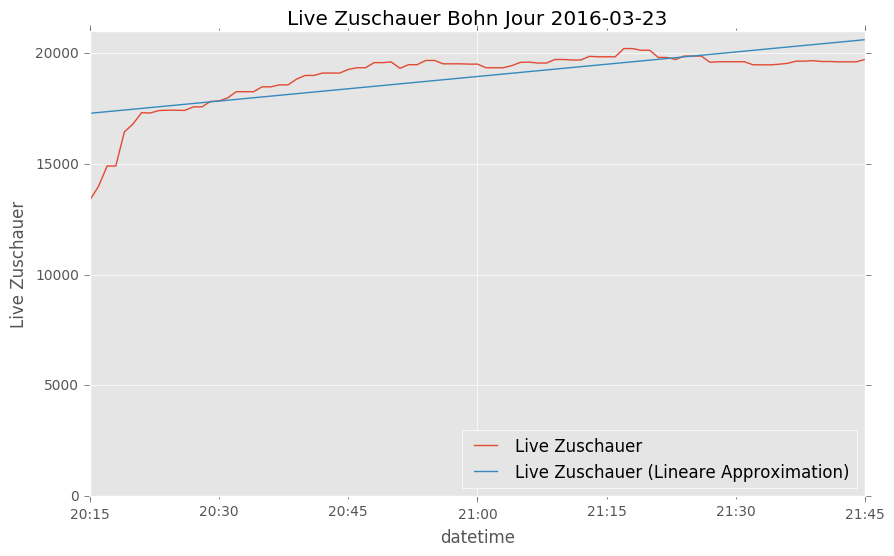

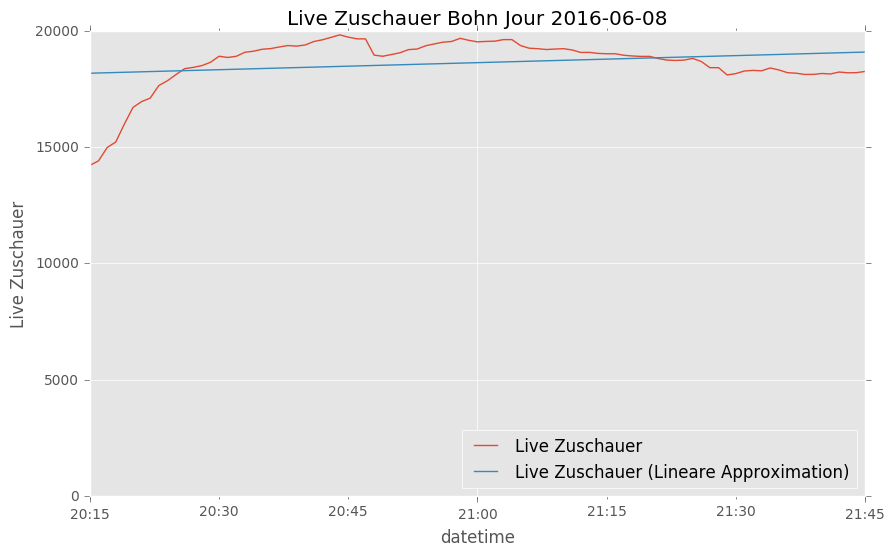

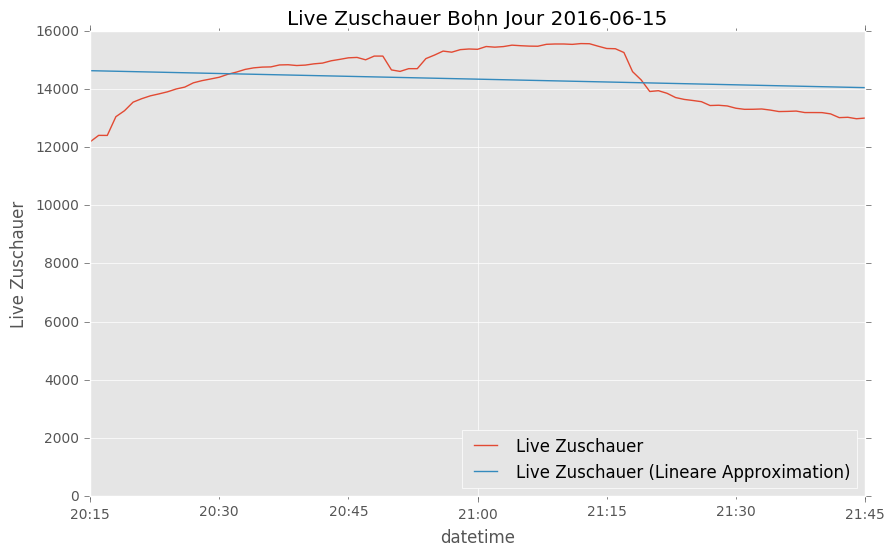

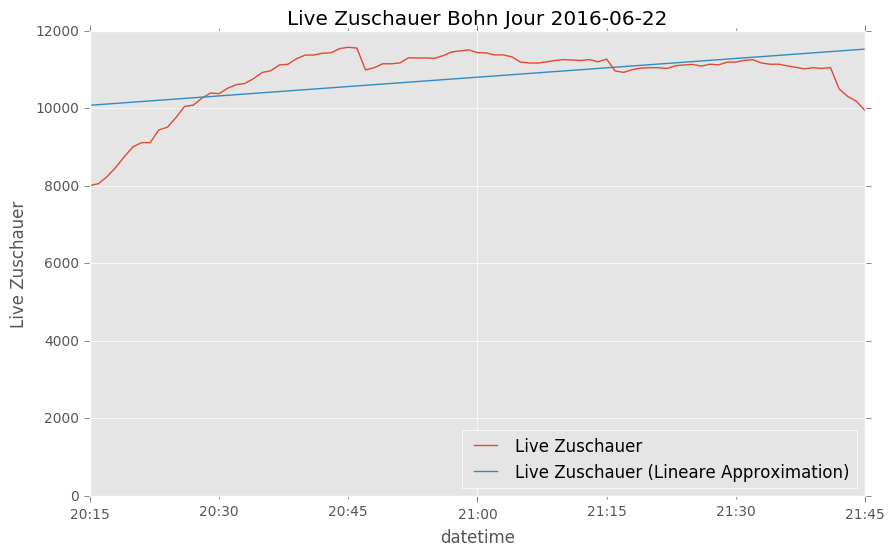

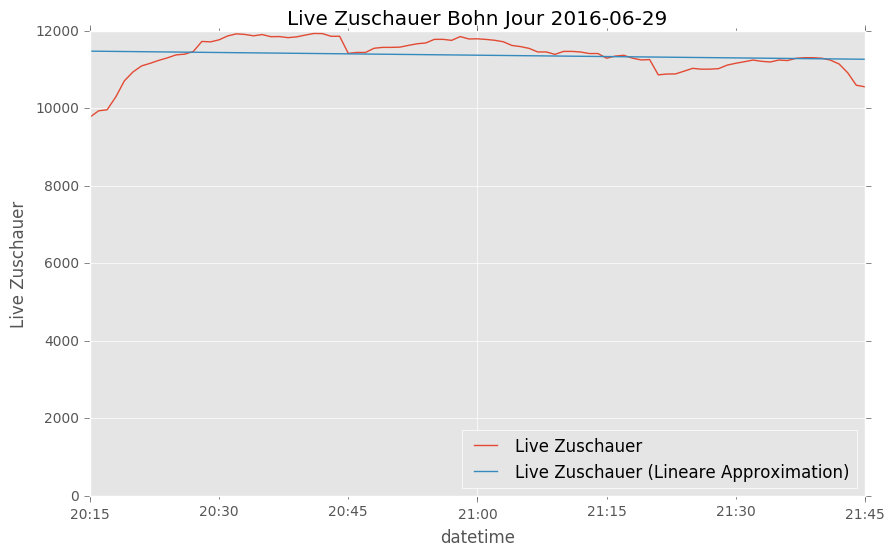

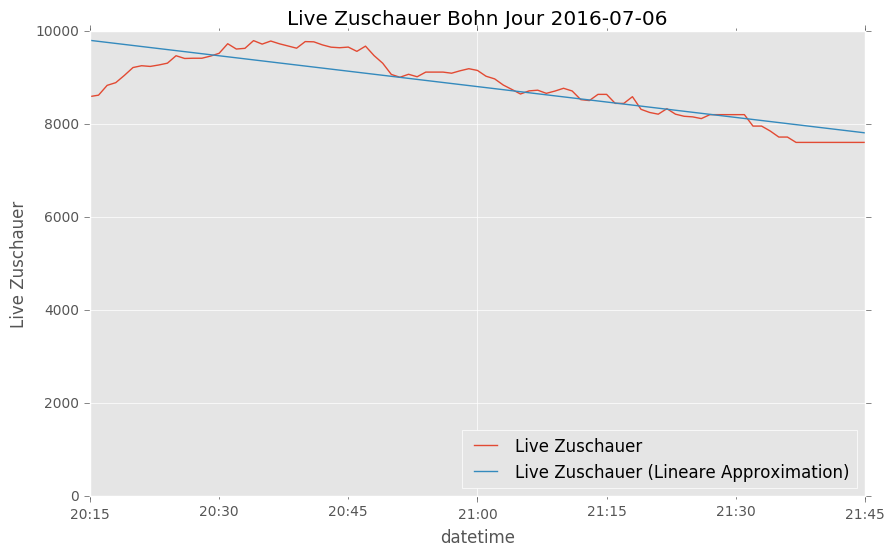

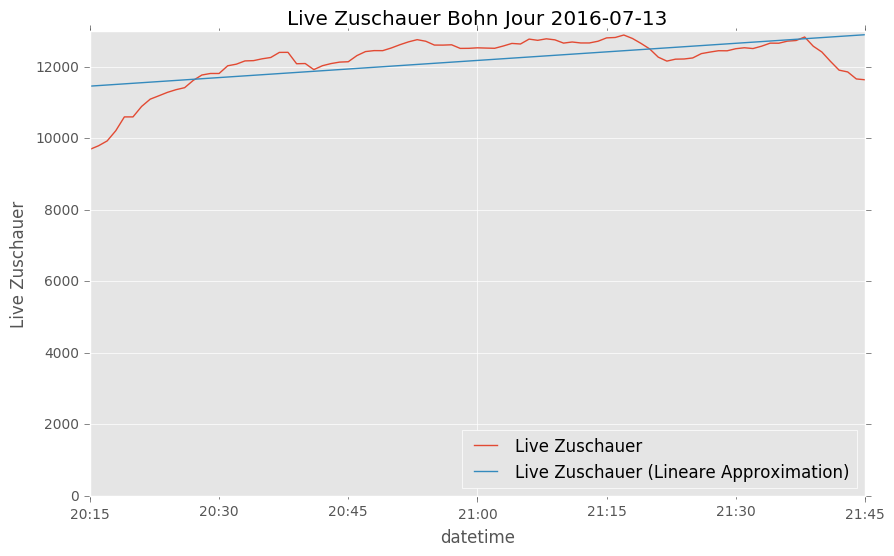

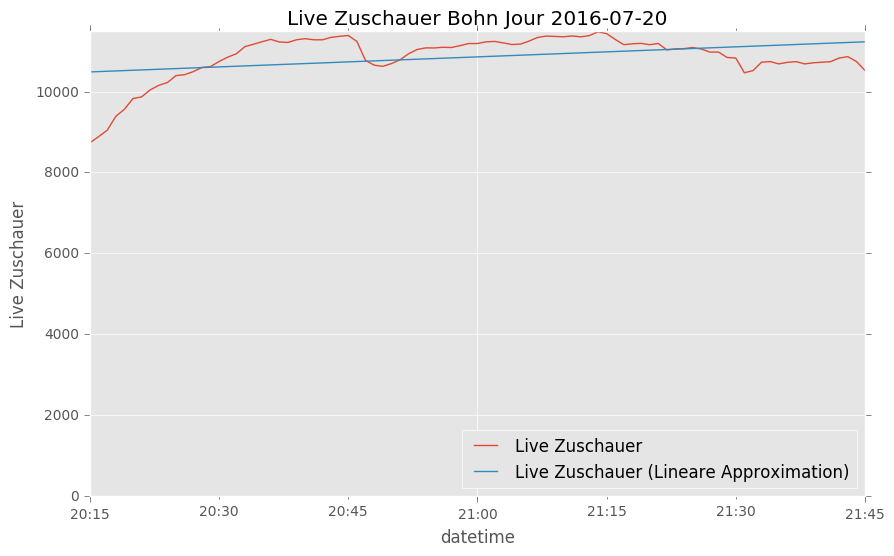

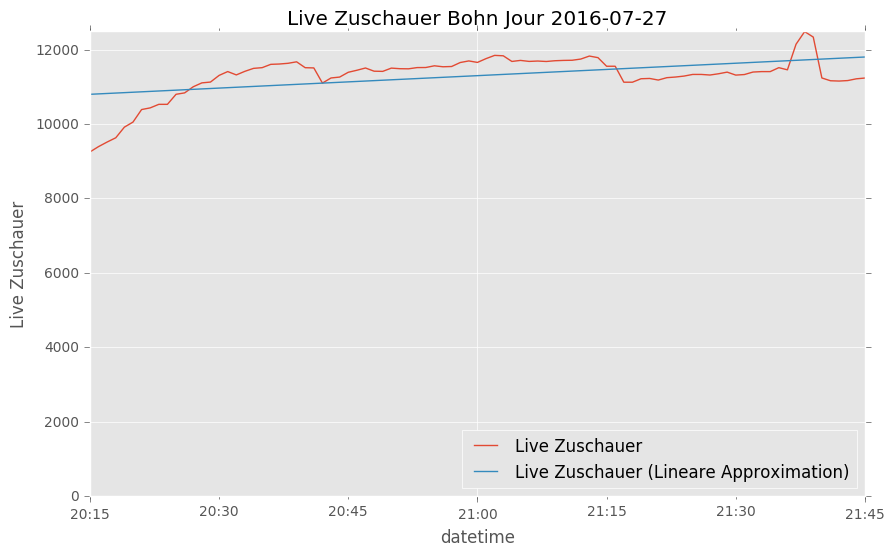

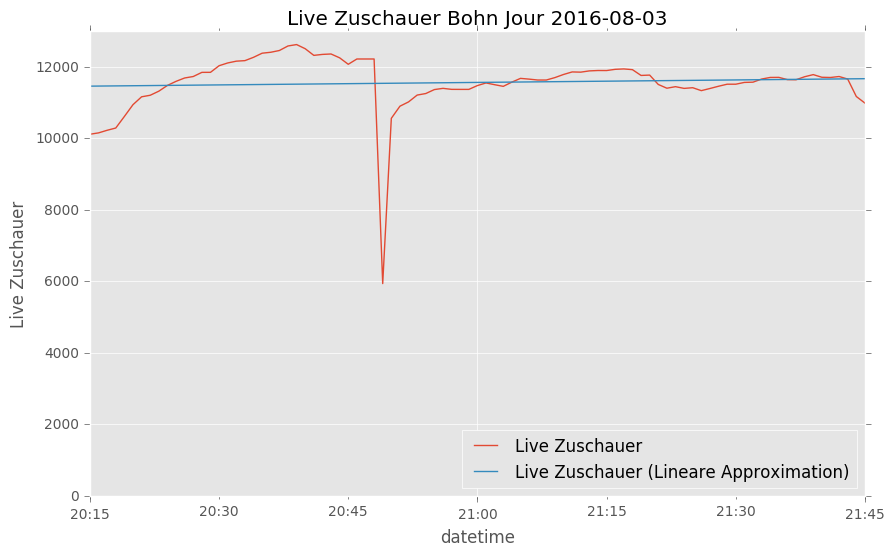

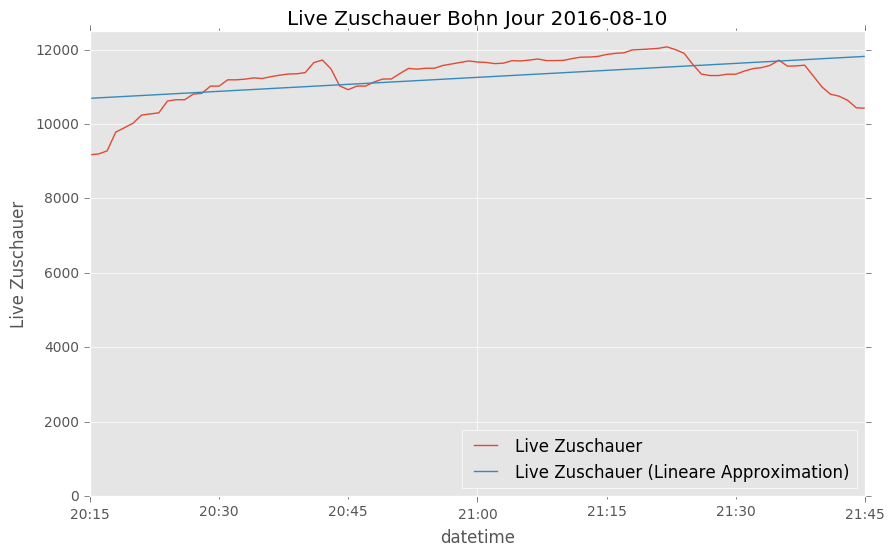

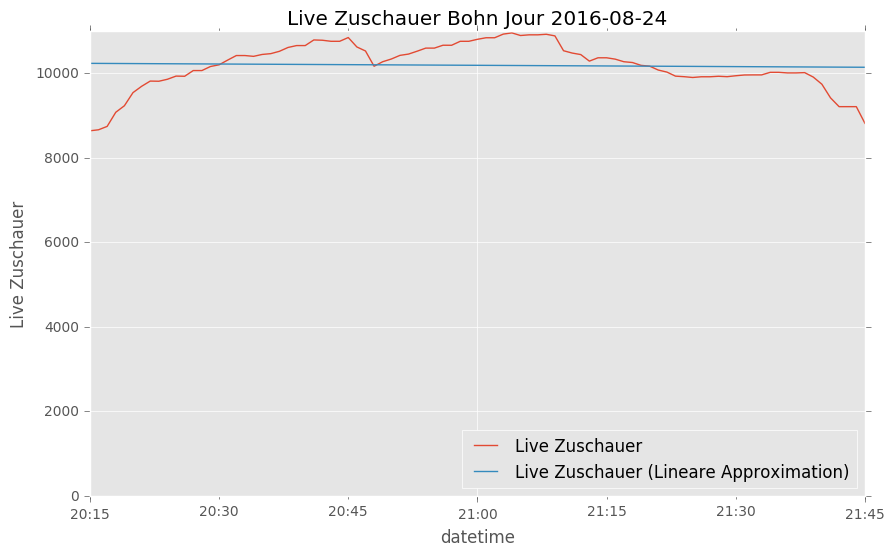

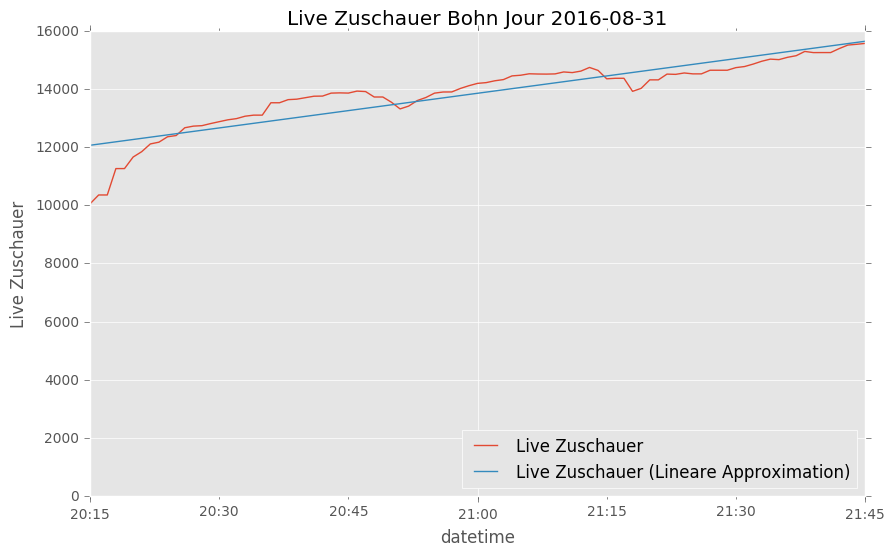

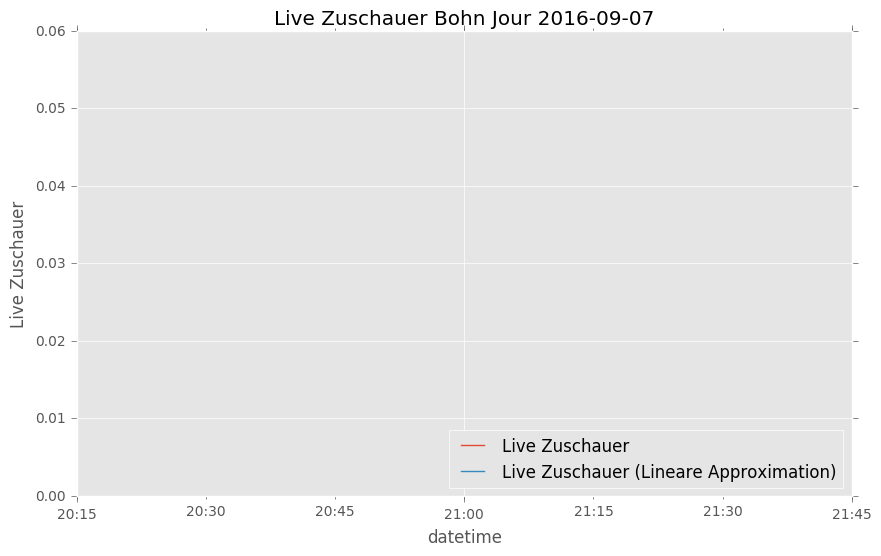

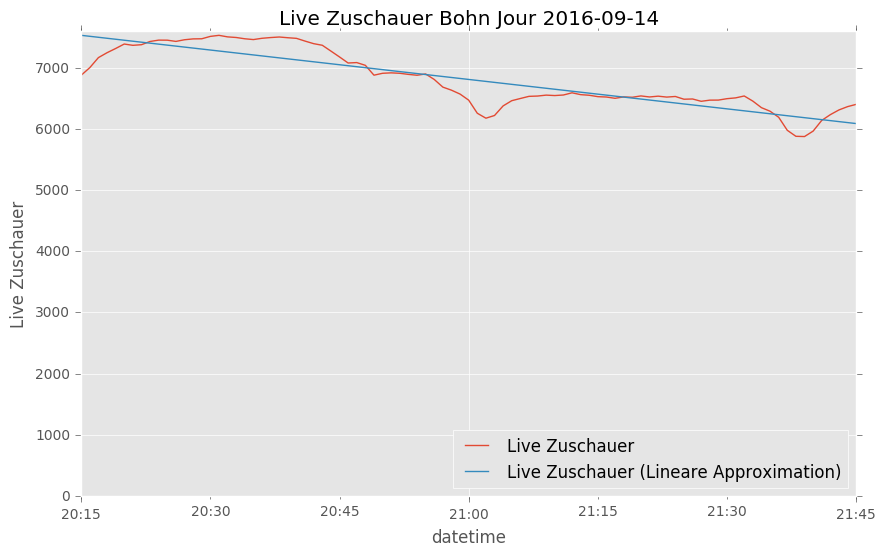

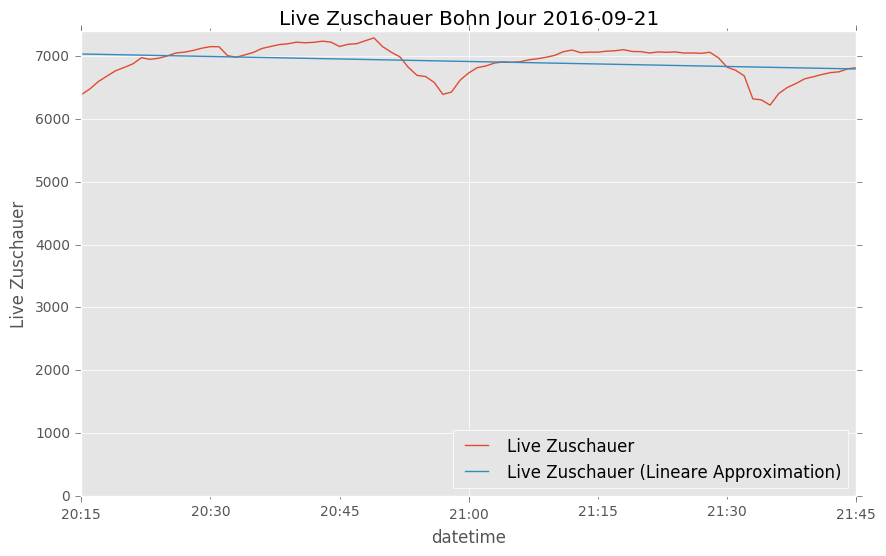

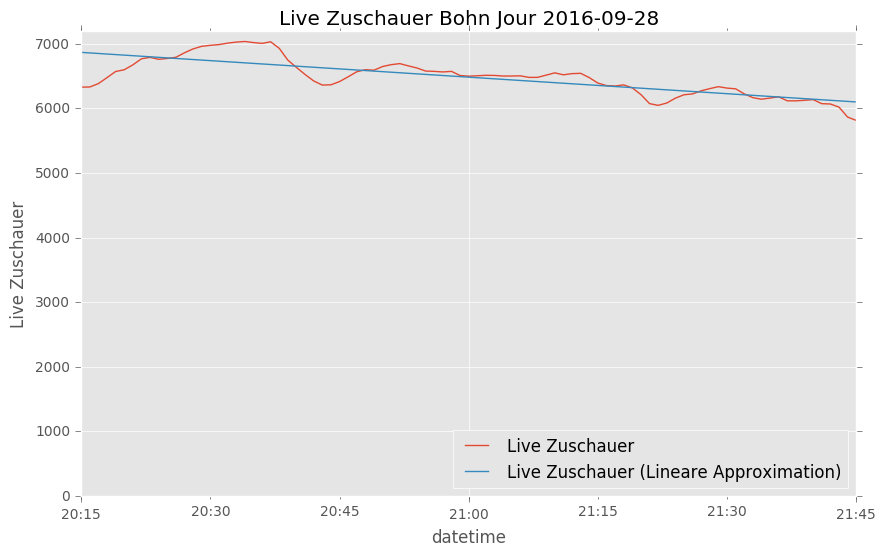

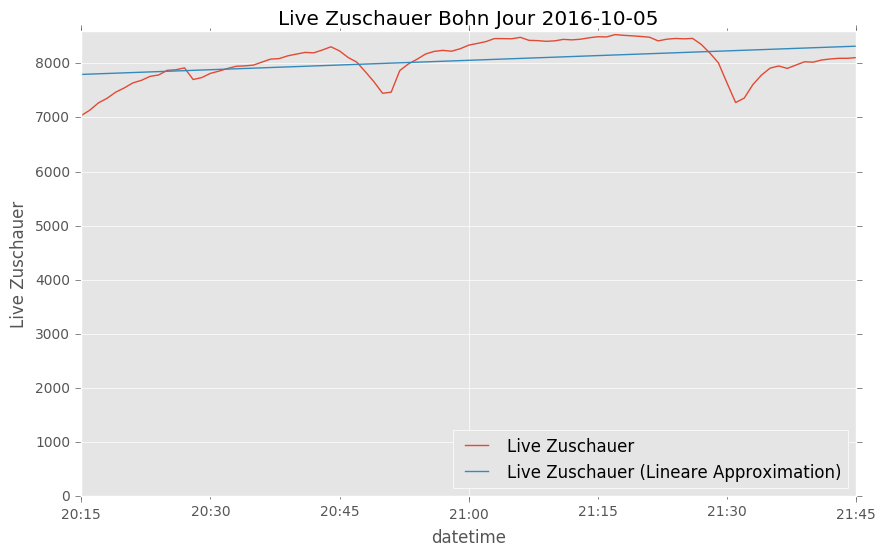

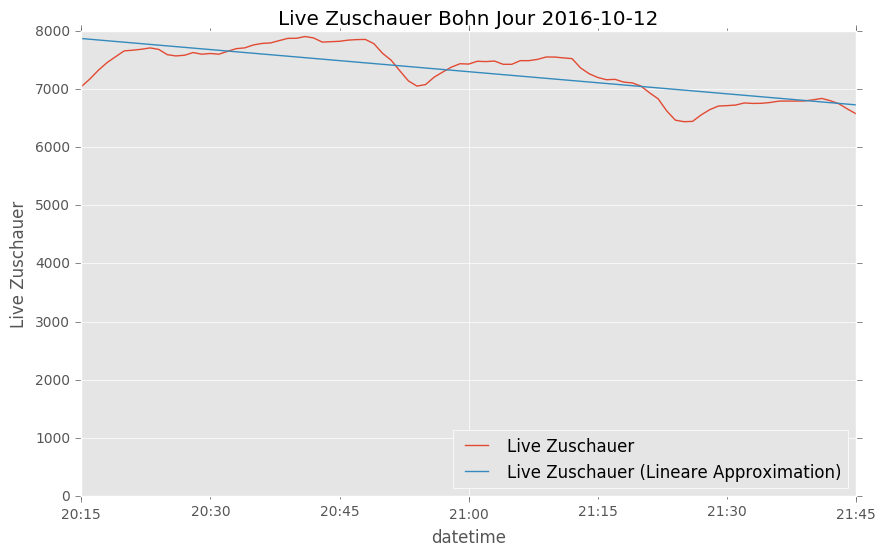

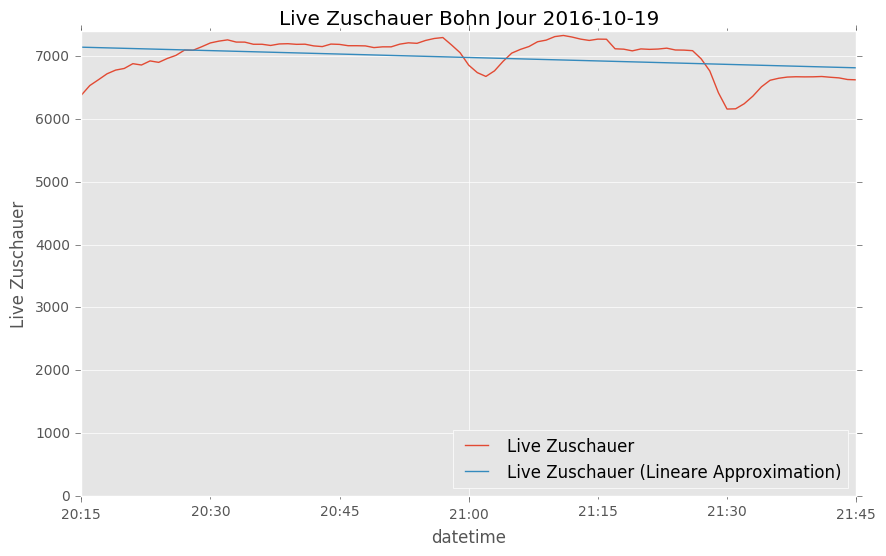

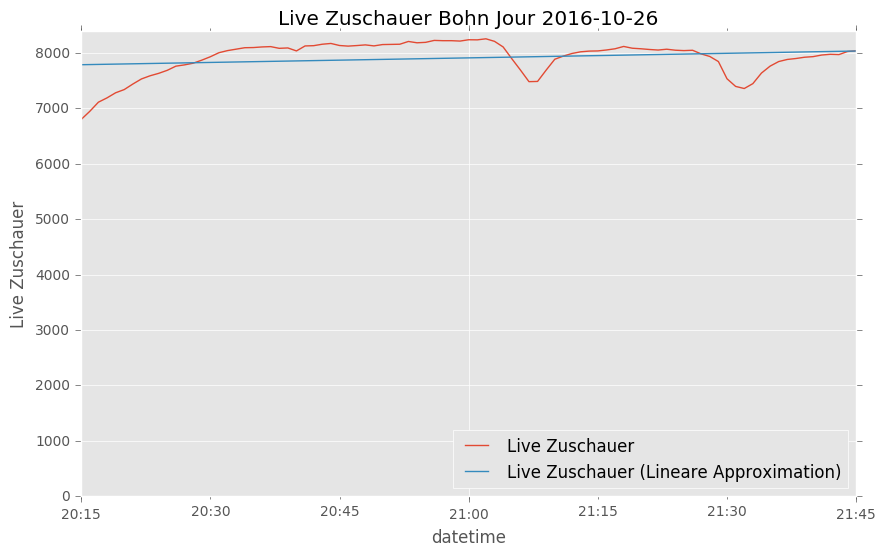

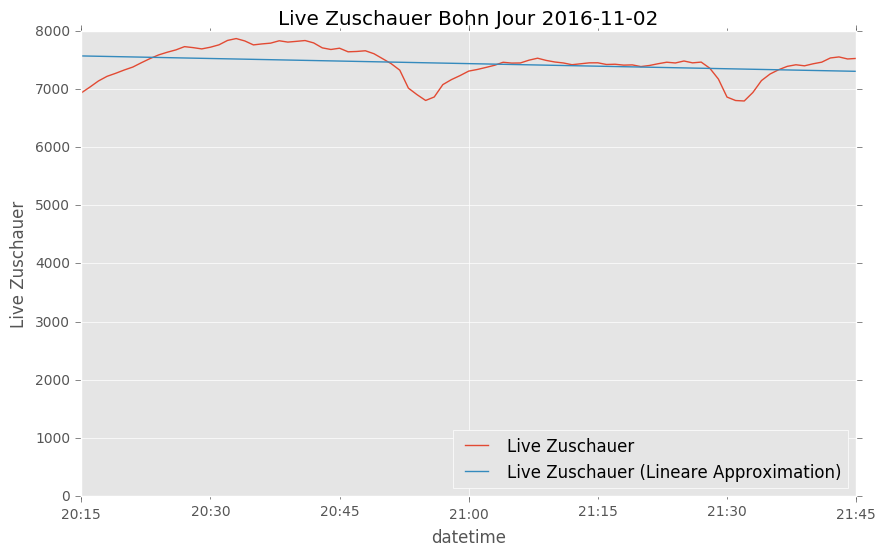

In [10]:
data = pd.DataFrame(columns=['live_views_mean', 
                             'live_views_slope',
                             'chat_messages', 
                             'chat_participants', 
                             'video_views_total',
                             'video_views_mean',
                             'video_views_drop',
                             'video_ratings_total',
                             'video_ratings_mean',
                             'video_ratings_like_total',
                             'video_ratings_like_mean',
                             'video_ratings_like_first',
                             'video_ratings_dislike_total',
                             'video_ratings_dislike_mean',
                             'video_ratings_dislike_first',
                             'video_ratings_ratio_total',
                             'video_ratings_ratio_mean',
                             'video_ratings_ratio_first',
                             'video_comments_total',
                             'video_comments_mean',
                             'video_comments_first'])

colors = []
for aired, videosGroup in videosGrouped:
    aired = aired.date()

    if aired < bohnJour2Date:
        colors.append(bohnJour1Color)
    elif aired < youtubeAraDate:
        colors.append(bohnJour2TwitchColor)
    else:
        colors.append(bohnJour2YoutubeColor)

    videosGroup = videosGroup.sort_values('part')

    start = datetime.datetime.combine(aired, datetime.time(20, 15, 0))
    end = datetime.datetime.combine(aired, datetime.time(21, 45, 0))

    #filter live data by date
    liveFiltered = live.loc[start : end]

    #calculate linear regression
    x = np.array(liveFiltered.index.strftime('%s').tolist()).astype(int)
    y = np.array(liveFiltered['viewers'].tolist())
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    y = intercept + slope * x

    liveFiltered['viewers_regression'] = y

    #calculate live mean
    liveViewsMean = liveFiltered['viewers'].mean()

    #slope
    liveViewsSlope = slope

    #filter chat data by date
    chatFiltered = chat.loc[start : end]

    #count chat messages
    chatMessages = len(chatFiltered)

    #count unique users
    chatParticipants = len(chatFiltered['username'].unique())

    #views
    videoViewsTotal = videosGroup['viewCount'].sum()
    videoViewsMean = videosGroup['viewCount'].mean()
    firstVideo = videosGroup['viewCount'][0]
    secondVideo = videosGroup['viewCount'][1]
    videoViewsDrop = 100 * (firstVideo - secondVideo) / float(firstVideo)

    #ratings
    videoRatingsTotal = videosGroup['ratings_total'].sum()
    videoRatingsMean = videosGroup['ratings_total'].mean()

    #likes
    videoRatingsLikeTotal = videosGroup['likeCount'].sum()
    videoRatingsLikeMean = videosGroup['likeCount'].mean()
    videoRatingsLikeFirst = videosGroup['likeCount'][0]

    #dislikes
    videoRatingsDislikeTotal = videosGroup['dislikeCount'].sum()
    videoRatingsDislikeMean = videosGroup['dislikeCount'].mean()
    videoRatingsDislikeFirst = videosGroup['dislikeCount'][0]

    #ratio
    videoRatingsRatioTotal = 100 * videoRatingsLikeTotal / float(videoRatingsTotal)
    videoRatingsRatioMean = videosGroup['ratings_ratio'].mean()
    videoRatingsRatioFirst = videosGroup['ratings_ratio'][0]

    #comments
    videoCommentsTotal = videosGroup['commentCount'].sum()
    videoCommentsMean = videosGroup['commentCount'].mean()
    videoCommentsFirst = videosGroup['commentCount'][0]

    data.loc[aired] = [liveViewsMean, 
                       liveViewsSlope, 
                       chatMessages, 
                       chatParticipants, 
                       videoViewsTotal,
                       videoViewsMean,
                       videoViewsDrop,
                       videoRatingsTotal,
                       videoRatingsMean,
                       videoRatingsLikeTotal,
                       videoRatingsLikeMean,
                       videoRatingsLikeFirst,
                       videoRatingsDislikeTotal,
                       videoRatingsDislikeMean,
                       videoRatingsDislikeFirst,
                       videoRatingsRatioTotal,
                       videoRatingsRatioMean,
                       videoRatingsRatioFirst,
                       videoCommentsTotal,
                       videoCommentsMean,
                       videoCommentsFirst]

    plot = liveFiltered[['viewers', 'viewers_regression']].plot(kind='line', figsize=(10, 6), legend=False, title='Live Zuschauer Bohn Jour %s' % aired)
    plot.set_ylabel('Live Zuschauer')

    legend = plot.legend(loc=4)
    legend.get_texts()[0].set_text('Live Zuschauer')
    legend.get_texts()[1].set_text('Live Zuschauer (Lineare Approximation)')

    plt.ylim(ymin=0)
    plt.show()

In [11]:
data

,live_views_mean,live_views_slope,chat_messages,chat_participants,video_views_total,video_views_mean,video_views_drop,video_ratings_total,video_ratings_mean,video_ratings_like_total,video_ratings_like_mean,video_ratings_like_first,video_ratings_dislike_total,video_ratings_dislike_mean,video_ratings_dislike_first,video_ratings_ratio_total,video_ratings_ratio_mean,video_ratings_ratio_first,video_comments_total,video_comments_mean,video_comments_first
2015-08-05,11547.549451,-1.118148,3265.0,1008.0,110463.0,36821.000000,32.830262,3391.0,1130.333333,3344.0,1114.666667,1481.0,47.0,15.666667,21.0,98.613978,98.623567,98.601864,315.0,105.000000,123.0
2015-08-12,13877.197802,0.408935,9987.0,1819.0,94605.0,31535.000000,15.294281,2591.0,863.666667,2527.0,842.333333,1008.0,64.0,21.333333,24.0,97.529911,97.504121,97.674419,242.0,80.666667,112.0
2015-08-26,13548.615385,0.301143,9327.0,1688.0,76427.0,25475.666667,35.483346,2443.0,814.333333,2407.0,802.333333,991.0,36.0,12.000000,17.0,98.526402,98.551928,98.313492,296.0,98.666667,160.0
2015-09-02,13680.406593,0.478941,10612.0,1832.0,88685.0,29561.666667,8.201247,2373.0,791.000000,2338.0,779.333333,865.0,35.0,11.666667,14.0,98.525074,98.526921,98.407281,292.0,97.333333,125.0
2015-09-09,13872.197802,0.602278,9042.0,1788.0,95622.0,31874.000000,6.516654,3008.0,1002.666667,2994.0,998.000000,1022.0,14.0,4.666667,5.0,99.534574,99.539559,99.513145,257.0,85.666667,95.0
2015-09-16,12712.065934,0.393110,12505.0,1911.0,101234.0,33744.666667,10.670159,3194.0,1064.666667,3129.0,1043.000000,1025.0,65.0,21.666667,30.0,97.964934,97.914575,97.156398,449.0,149.666667,148.0
2015-09-23,12809.472527,0.075239,10435.0,1739.0,80190.0,26730.000000,29.193666,2515.0,838.333333,2482.0,827.333333,1123.0,33.0,11.000000,8.0,98.687873,98.562355,99.292661,260.0,86.666667,107.0
2015-09-30,12151.879121,0.120818,13619.0,2476.0,70074.0,23358.000000,12.233010,1959.0,653.000000,1892.0,630.666667,745.0,67.0,22.333333,33.0,96.579888,96.667403,95.758355,326.0,108.666667,228.0
2015-10-07,14035.890110,0.369195,13966.0,2408.0,80998.0,26999.333333,23.860021,2151.0,717.000000,2051.0,683.666667,804.0,100.0,33.333333,12.0,95.351000,95.214416,98.529412,299.0,99.666667,95.0
2015-10-14,15071.582418,0.697082,16734.0,2457.0,81846.0,27282.000000,-29.853902,2366.0,788.666667,2336.0,778.666667,718.0,30.0,10.000000,5.0,98.732037,98.828193,99.308437,288.0,96.000000,87.0


## Live Zuschauer

Die durchschnittlichen Zuschauer von Bohn Jour im Zeitraum von 20:15 Uhr bis 21:45 Uhr.

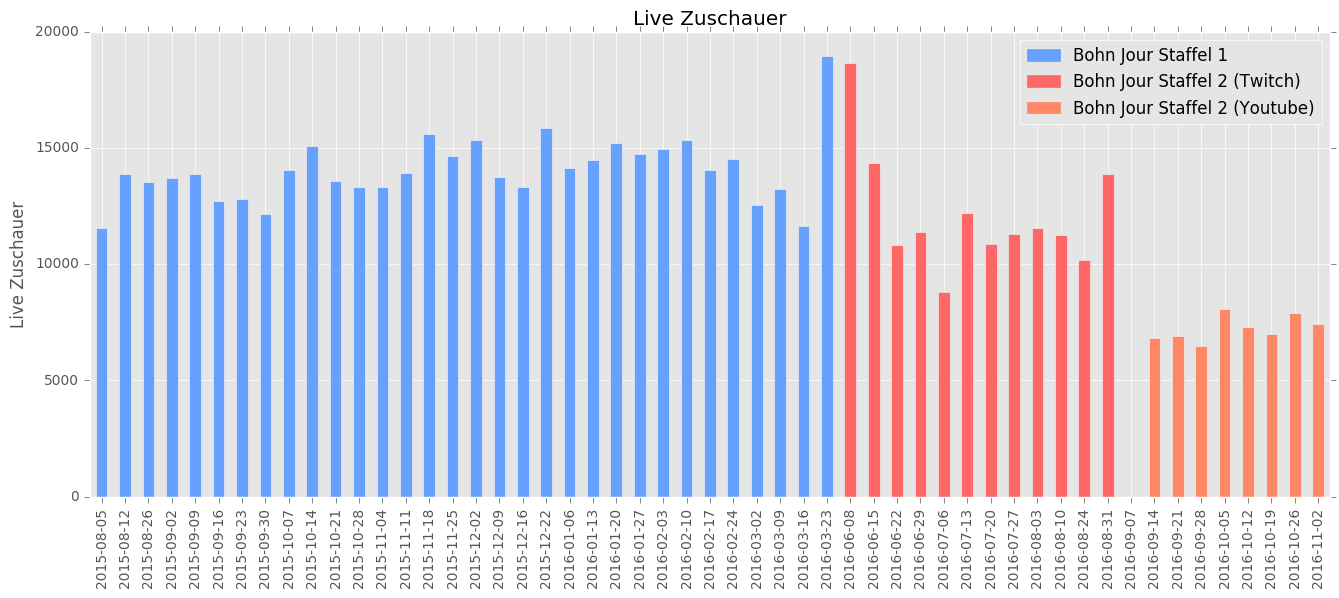

In [12]:
plot = data['live_views_mean'].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Live Zuschauer')
plot.set_ylabel('Live Zuschauer')

plot.legend(loc=0, handles=bohnJourLegend)

In [13]:
joinedData = aggColumn(data, 'live_views_mean')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,32.000000,12.000000,8.000000
mean,14049.590602,12095.740842,7236.333791
std,1411.100375,2536.104068,547.333284
min,11547.549451,8803.230769,6484.340659
25%,13307.755495,10845.717033,6887.425824
50%,13889.478022,11336.049451,7138.236264
75%,14776.409341,12595.489011,7556.730769
max,18942.802198,18636.076923,8057.032967


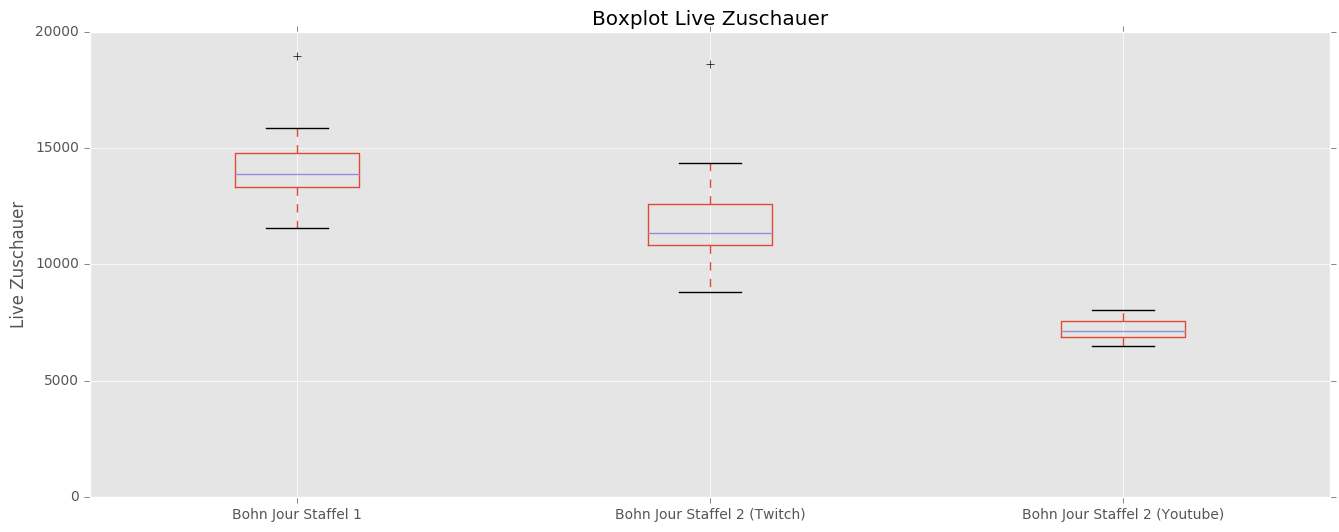

In [14]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Live Zuschauer')
plot.set_ylabel('Live Zuschauer')

plt.ylim(ymin=0)

plot

## Live Zuschauer Steigung

Die Steigung bezieht sich auf die lineare Approximation der Live Zuschauer, vom Anfang bis zum Ende von Bohn Jour. Diese Gerade ist auch oben in den Diagrammen zum Verlauf der Live Zuschauer eingezeichnet. Ein negativer Wert stellt einen Zuschauerschwund dar, ein positiver Wert einen Zuschauerwachstum.

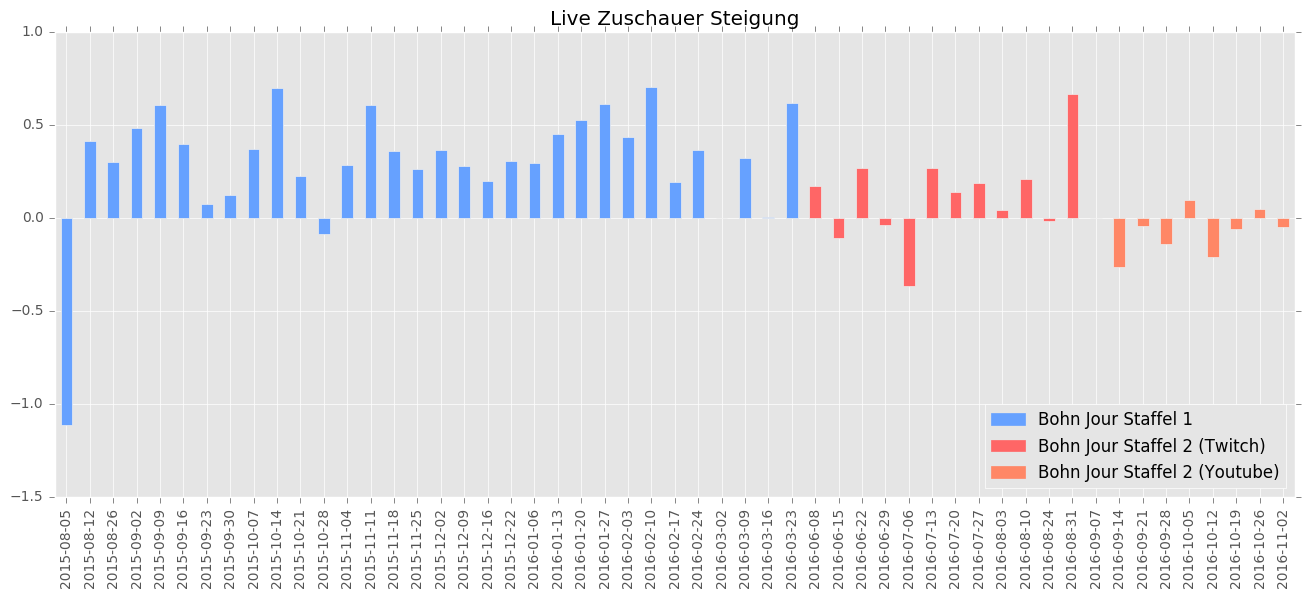

In [15]:
plot = data['live_views_slope'].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Live Zuschauer Steigung')

plot.legend(loc=0, handles=bohnJourLegend)

plot

In [16]:
joinedData = aggColumn(data, 'live_views_slope')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,31.000000,12.000000,8.000000
mean,0.310251,0.117016,-0.079019
std,0.327523,0.251137,0.122947
min,-1.118148,-0.368408,-0.267080
25%,0.242866,-0.022490,-0.159484
50%,0.355038,0.153110,-0.054924
75%,0.463962,0.223105,-0.021655
max,0.703575,0.662663,0.096732


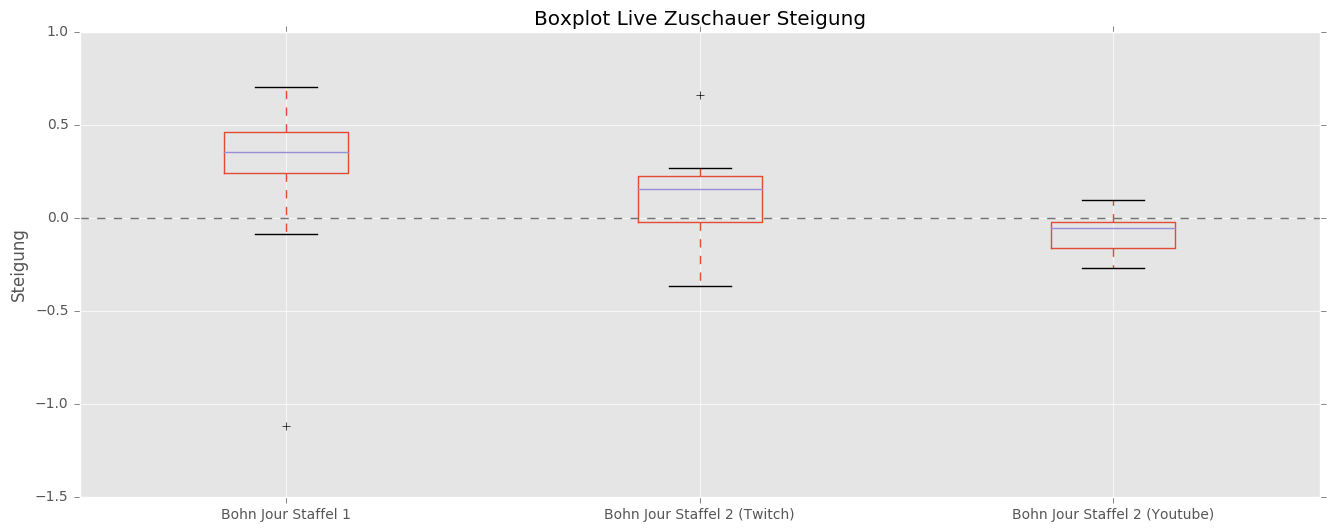

In [17]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Live Zuschauer Steigung')
plot.set_ylabel('Steigung')

plt.axhline(y=0, color='#727272',ls='dashed')

## Chat Nachrichten & Teilnehmer

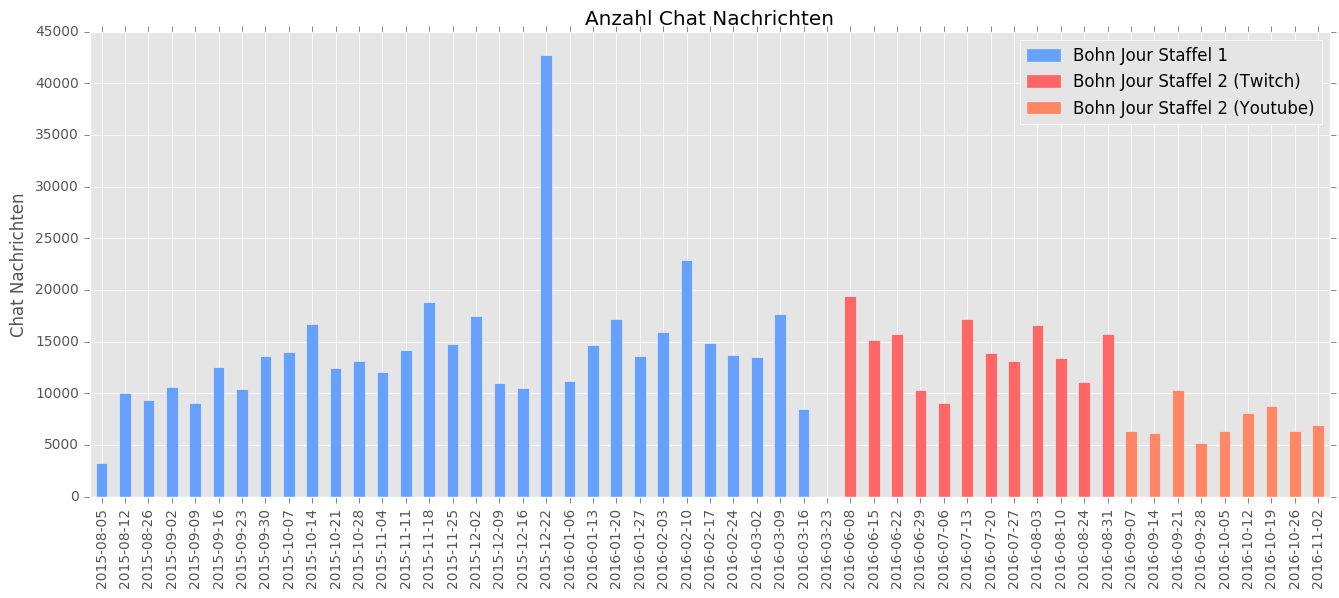

In [18]:
plot = data[['chat_messages']].plot(kind='bar', figsize=(16, 6), legend=False, color=colors, title='Anzahl Chat Nachrichten')
plot.set_ylabel('Chat Nachrichten')

plot.legend(loc=0, handles=bohnJourLegend)

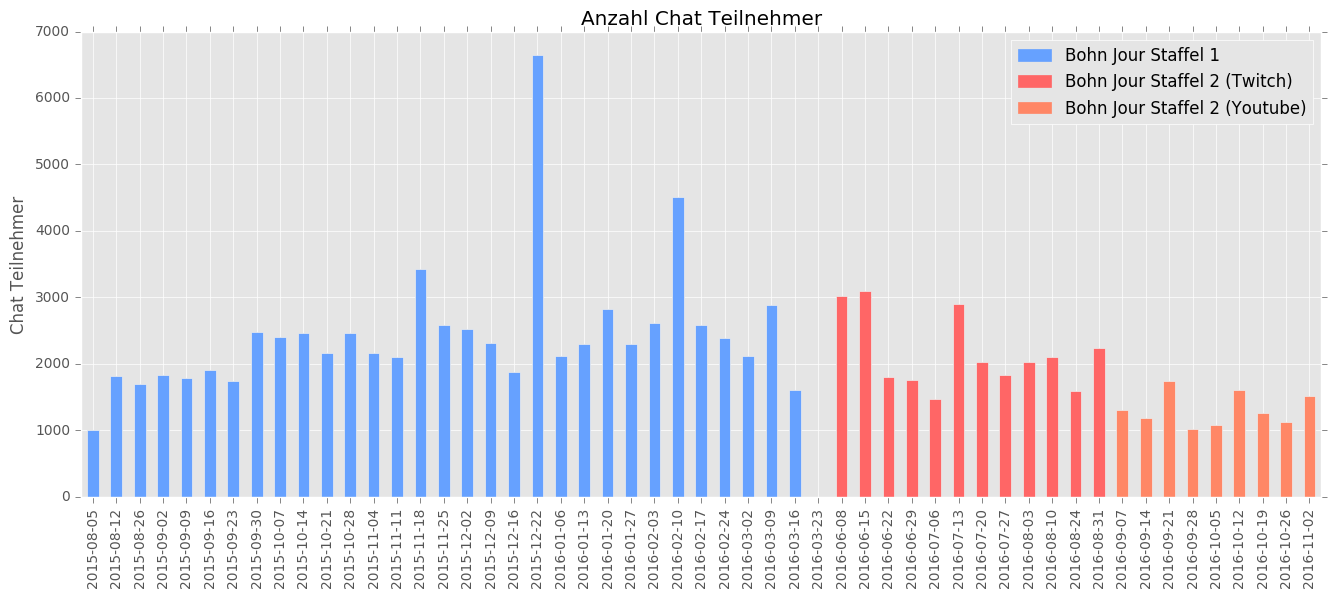

In [19]:
plot = data[['chat_participants']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl Chat Teilnehmer')
plot.set_ylabel('Chat Teilnehmer')

plot.legend(loc=0, handles=bohnJourLegend)

## Video Views

Alle nachfolgenden Daten beziehen sich auf die Video Views auf Youtube. Bohn Jour besteht i. d. R. aus 3 Teilen. Im folgenden wird unterschieden zwischen:

- __Gesamte Views__: Die Summe der Views aller Video Teile
- __Durchschnittliche Views__: Das arithmetische Mittel der Views aus allen Video Teilen

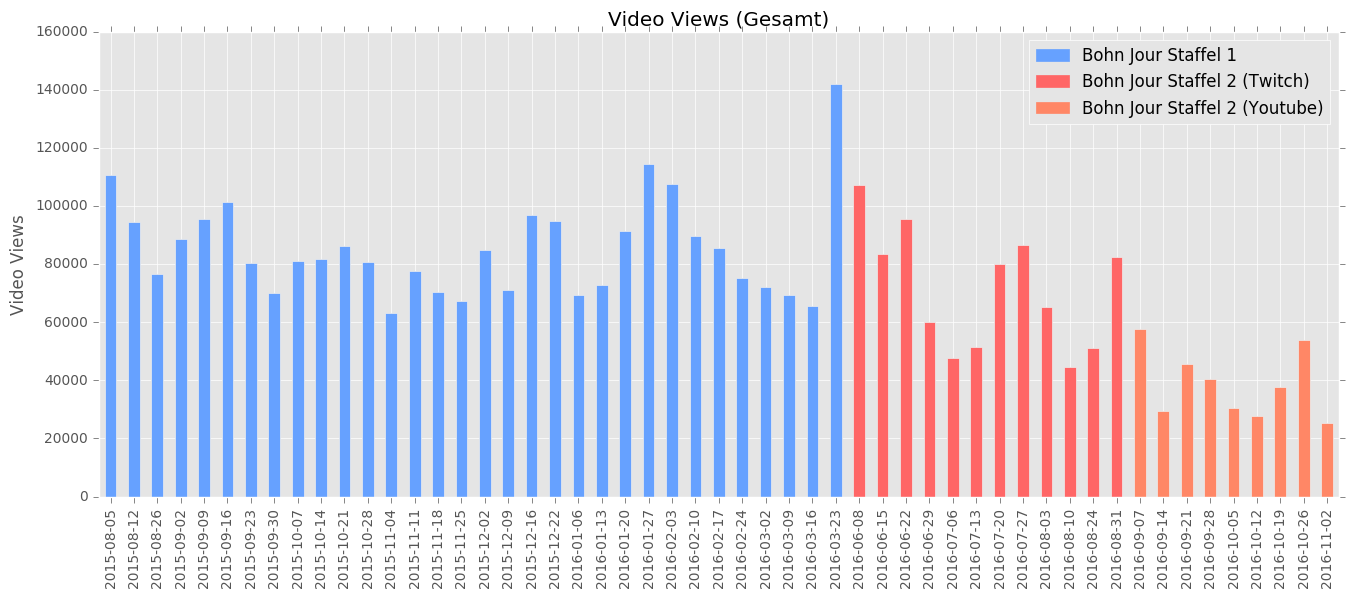

In [20]:
plot = data[['video_views_total']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Video Views (Gesamt)')
plot.set_ylabel('Video Views')

plot.legend(loc=0, handles=bohnJourLegend)

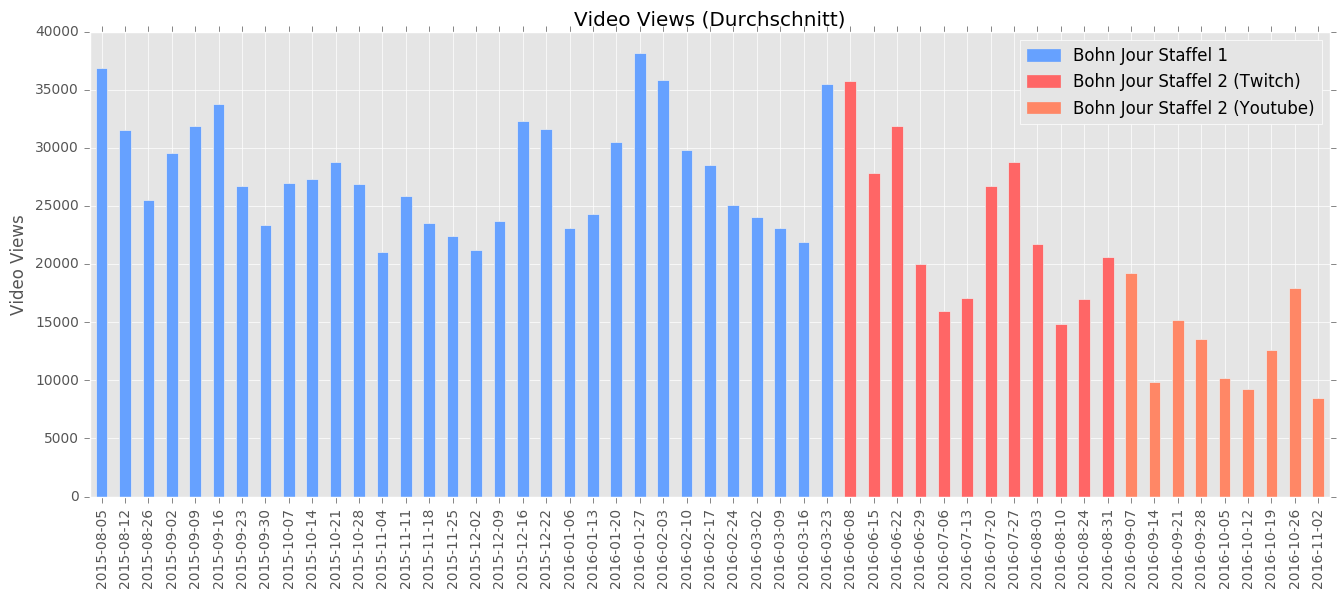

In [21]:
plot = data[['video_views_mean']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Video Views (Durchschnitt)')
plot.set_ylabel('Video Views')

plot.legend(loc=0, handles=bohnJourLegend)

In [22]:
joinedData = aggColumn(data, 'video_views_mean')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,32.000000,12.000000,9.000000
mean,27822.877604,23170.652778,12912.259259
std,4847.991612,6838.221364,3882.421430
min,21002.666667,14806.333333,8479.333333
25%,23638.250000,17073.583333,9822.000000
50%,26933.166667,21170.750000,12608.333333
75%,31559.333333,28068.916667,15216.333333
max,38151.666667,35713.333333,19202.000000


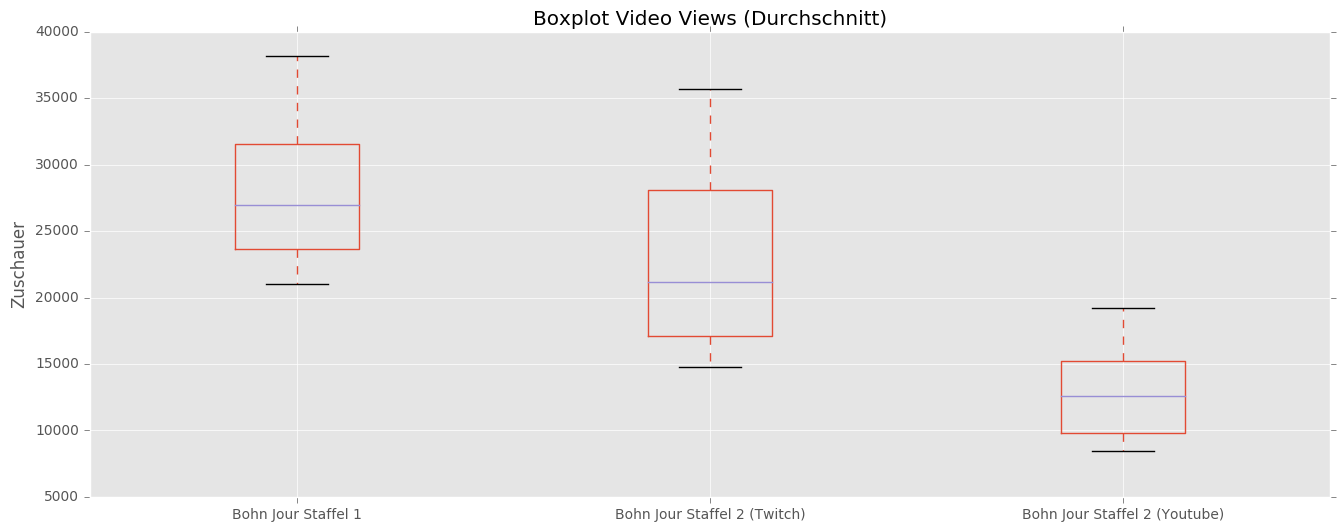

In [23]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Video Views (Durchschnitt)')
plot.set_ylabel('Zuschauer')

## Video Views Änderung

Die Änderung der Differenz der Video Views vom ersten und zweiten Video Teil. Bei einem positiven Wert wurde der zweite Teil weniger angeschaut als der erste, bei einem negativem Wert entsprechend mehr.

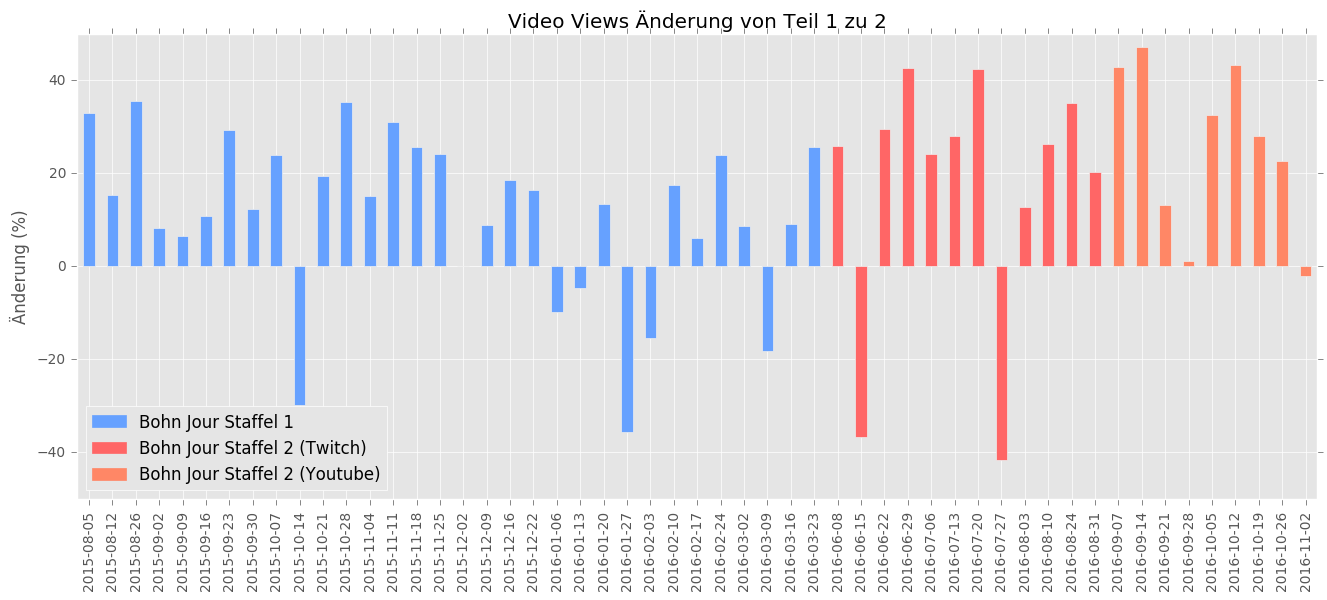

In [24]:
plot = data[['video_views_drop']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Video Views Änderung von Teil 1 zu 2')
plot.set_ylabel('Änderung (%)')

plot.legend(loc=0, handles=bohnJourLegend)

In [25]:
joinedData = aggColumn(data, 'video_views_drop')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,32.000000,12.000000,9.000000
mean,11.202013,17.316015,25.347402
std,17.806790,27.750900,18.244591
min,-35.719399,-41.659808,-2.102240
25%,6.408176,18.264181,13.018944
50%,14.193573,25.956081,27.873682
75%,23.895391,30.884145,42.759992
max,35.483346,42.499652,47.103548


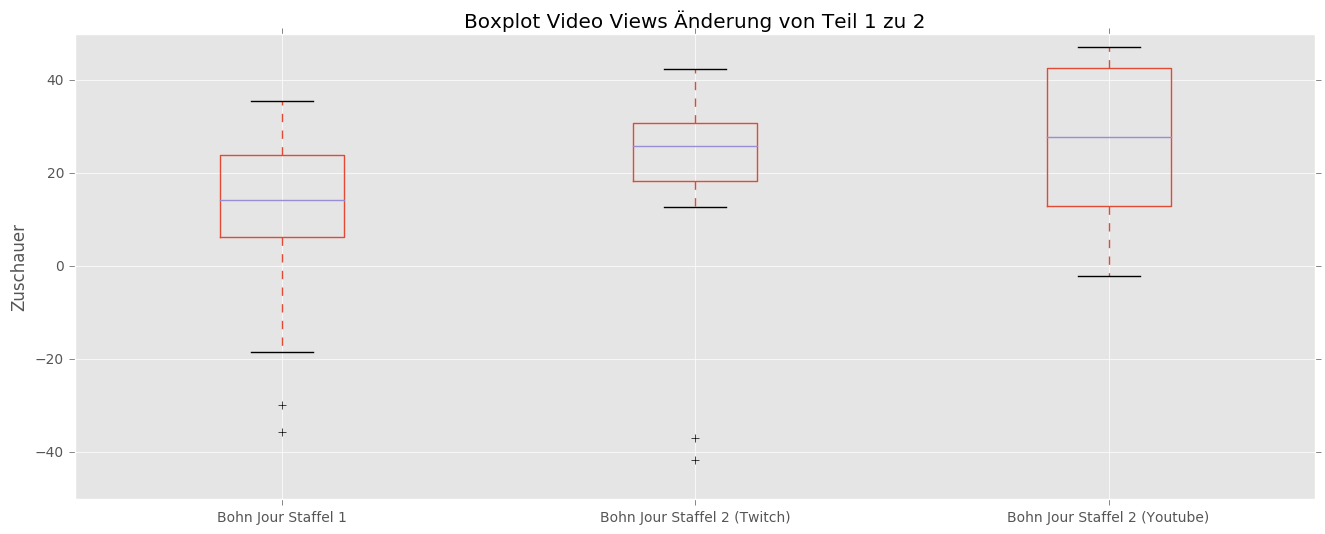

In [26]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Video Views Änderung von Teil 1 zu 2')
plot.set_ylabel('Zuschauer')

## Video Bewertungen

- __Gesamte Bewertungen__: Die Summe der Bewertungen aller Video Teile
- __Durchschnittliche Bewertungen__: Das arithmetische Mittel der Bewertungen aus allen Video Teilen

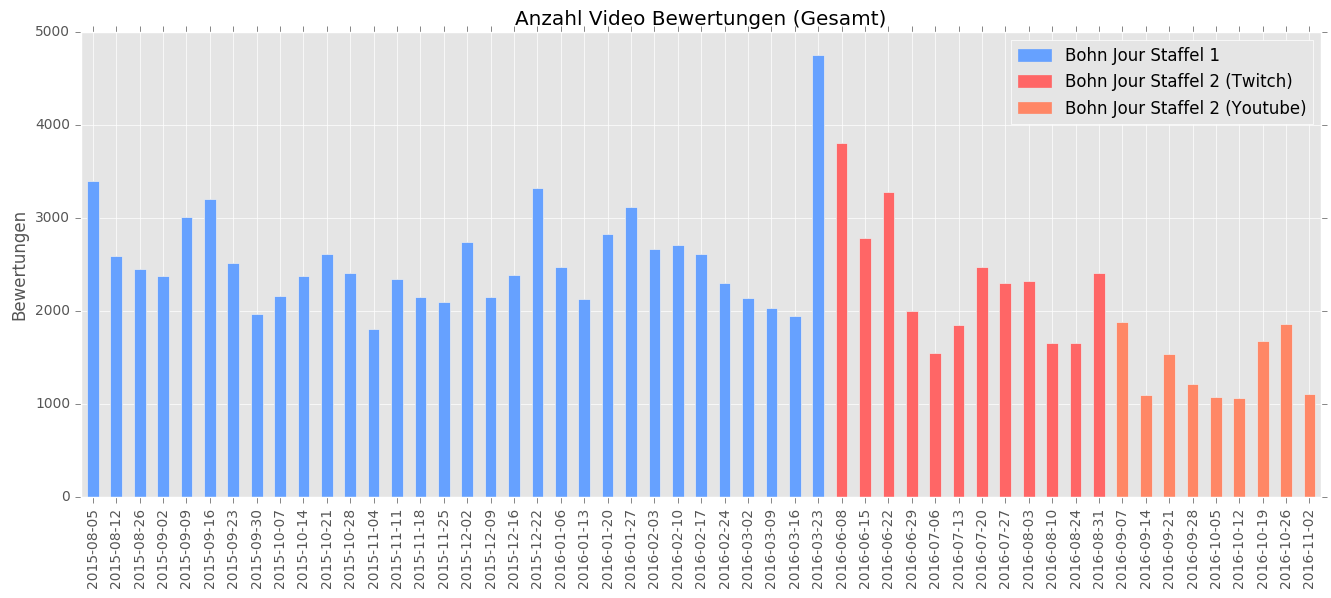

In [27]:
plot = data[['video_ratings_total']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl Video Bewertungen (Gesamt)')
plot.set_ylabel('Bewertungen')

plot.legend(loc=0, handles=bohnJourLegend)

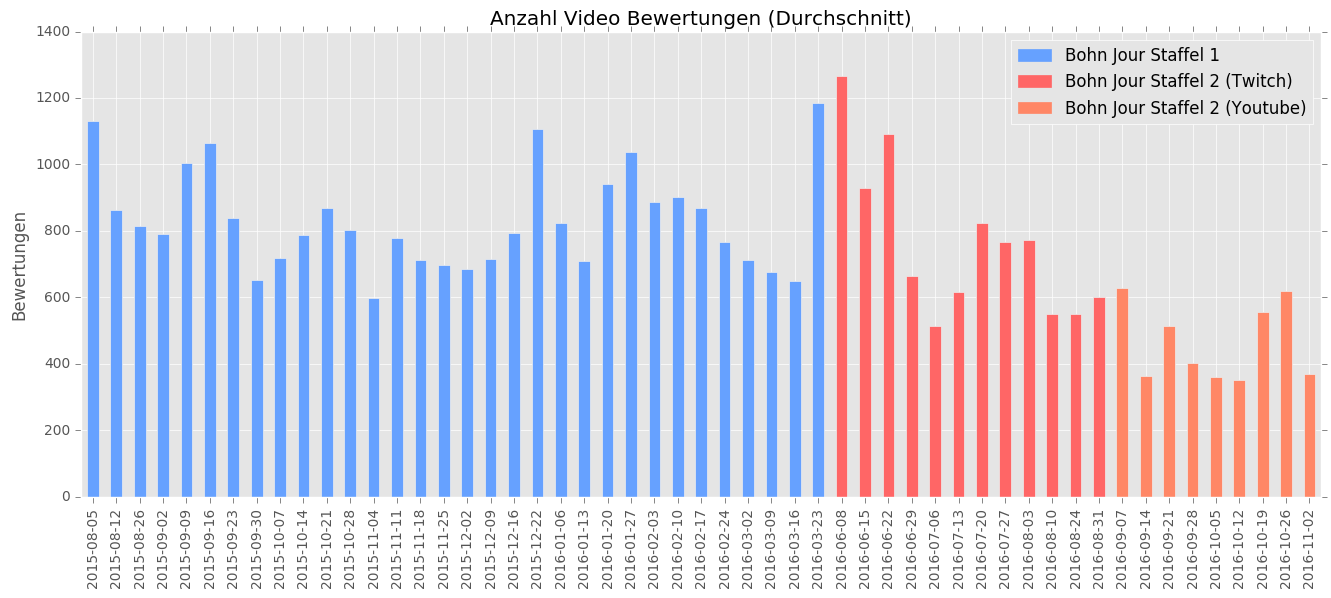

In [28]:
plot = data[['video_ratings_mean']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl Video Bewertungen (Durchschnitt)')
plot.set_ylabel('Bewertungen')

plot.legend(loc=0, handles=bohnJourLegend)

In [29]:
joinedData = aggColumn(data, 'video_ratings_mean')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,32.000000,12.000000,9.000000
mean,830.466146,761.687500,462.000000
std,150.925416,233.567924,116.568173
min,599.000000,514.000000,352.000000
25%,712.666667,588.687500,362.333333
50%,797.166667,715.333333,401.666667
75%,890.833333,848.666667,556.333333
max,1185.750000,1265.333333,626.666667


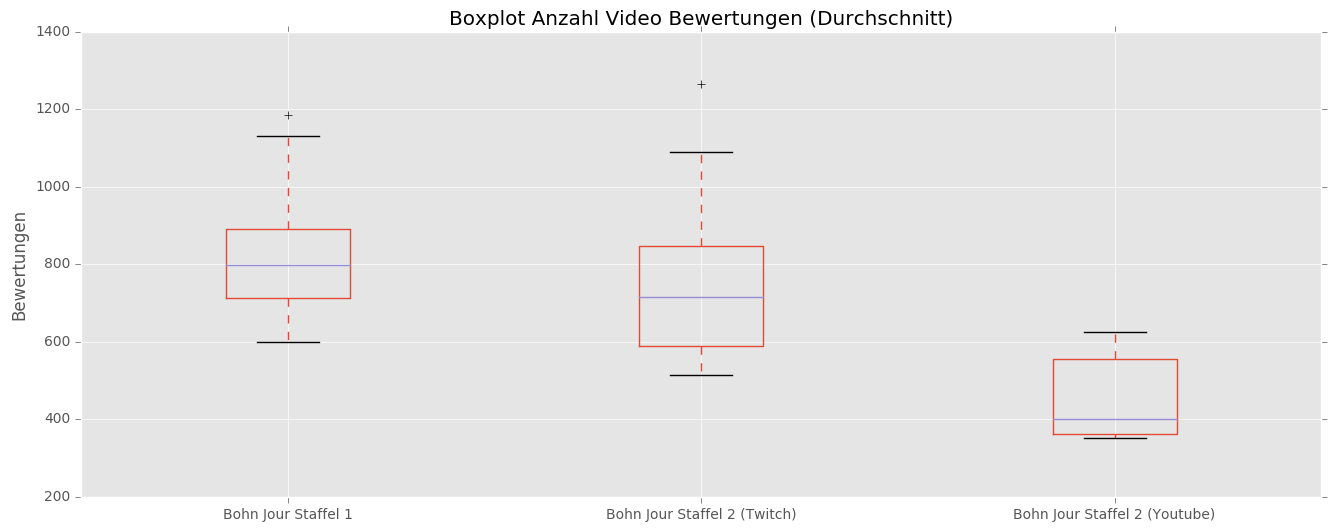

In [30]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Anzahl Video Bewertungen (Durchschnitt)')
plot.set_ylabel('Bewertungen')

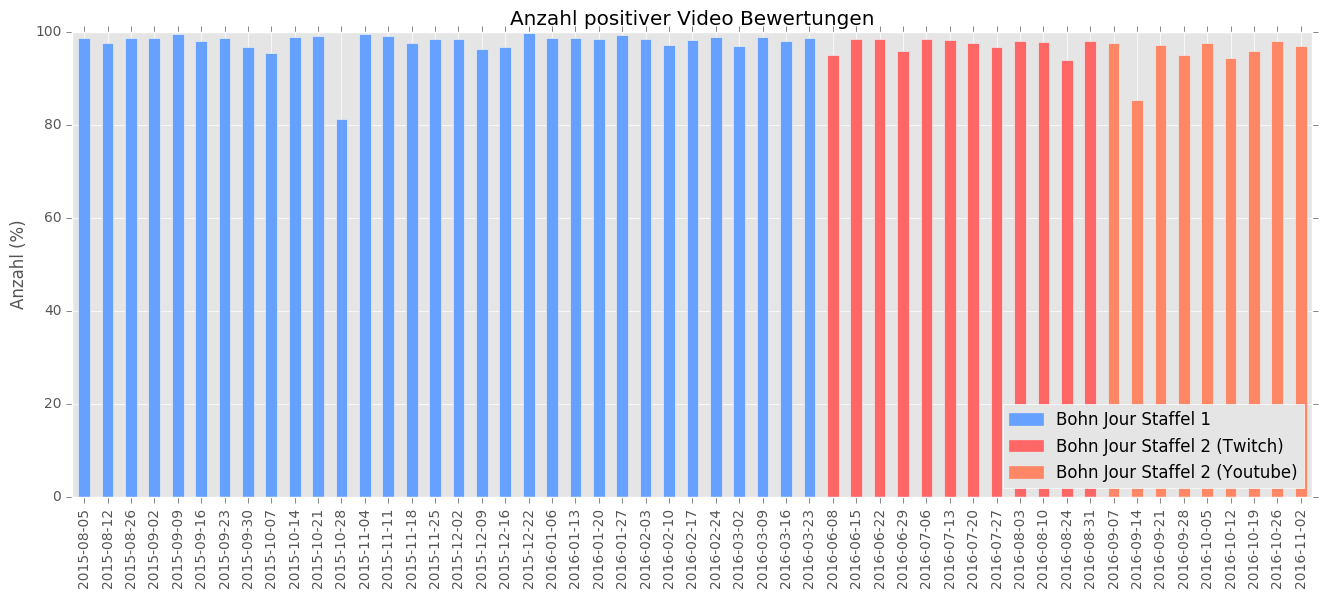

In [31]:
plot = data[['video_ratings_ratio_total']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl positiver Video Bewertungen')
plot.set_ylabel('Anzahl (%)')

plot.legend(loc=4, handles=bohnJourLegend)

## Video Kommentare

- __Gesamte Kommentare__: Die Summe der Kommentare aller Video Teile
- __Durchschnittliche Kommentare__: Das arithmetische Mittel der Kommentare aus allen Video Teilen

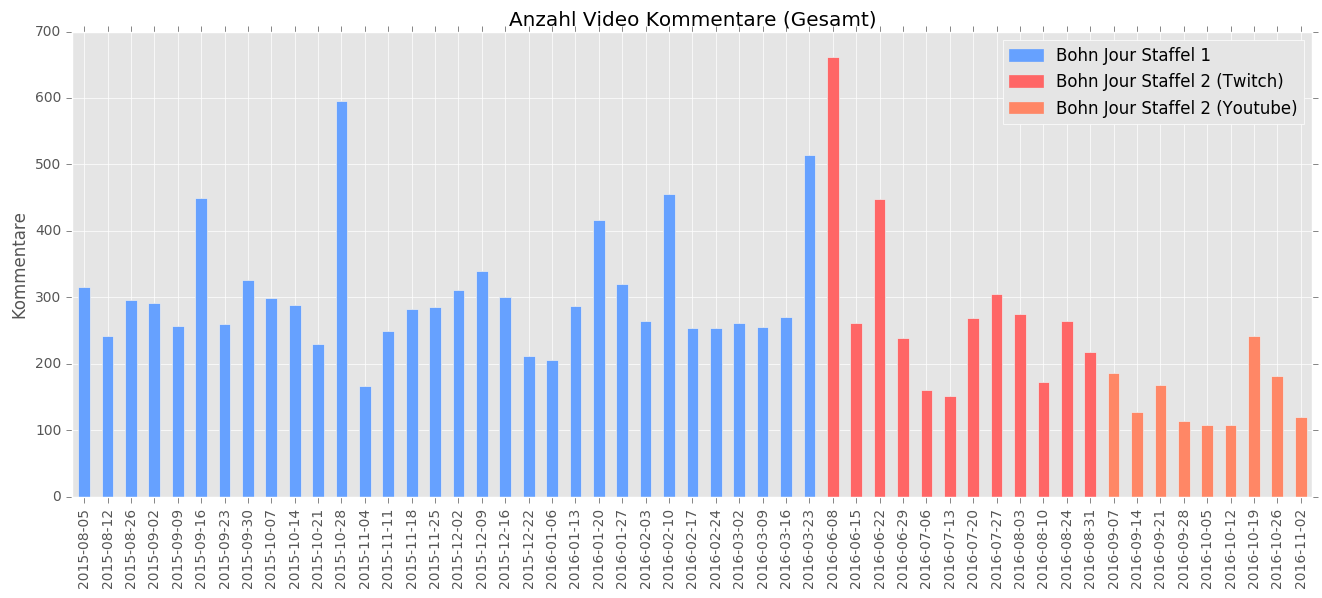

In [32]:
plot = data[['video_comments_total']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl Video Kommentare (Gesamt)')
plot.set_ylabel('Kommentare')

plot.legend(loc=0, handles=bohnJourLegend)

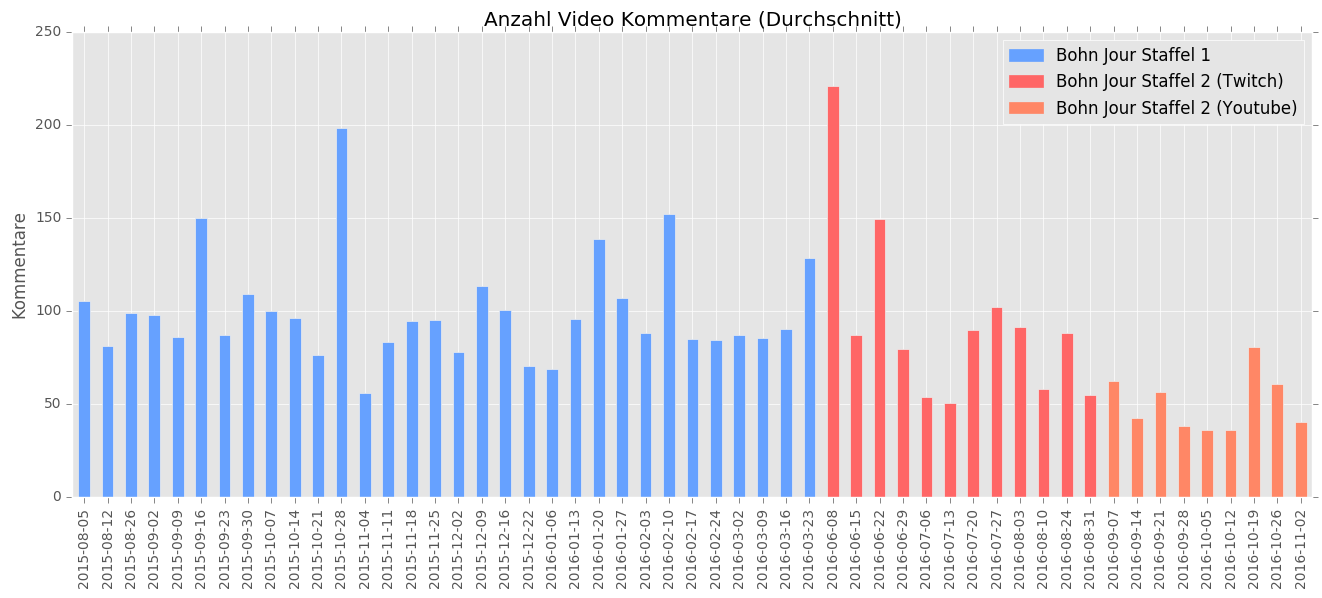

In [33]:
plot = data[['video_comments_mean']].plot(kind='bar', figsize=(16, 6), color=colors, legend=False, title='Anzahl Video Kommentare (Durchschnitt)')
plot.set_ylabel('Kommentare')

plot.legend(loc=0, handles=bohnJourLegend)

In [34]:
joinedData = aggColumn(data, 'video_comments_mean')

joinedData.describe()

,Bohn Jour Staffel 1,Bohn Jour Staffel 2 (Twitch),Bohn Jour Staffel 2 (Youtube)
count,32.000000,12.000000,9.000000
mean,99.414062,93.597222,50.111111
std,28.154205,48.526441,15.483863
min,55.666667,50.333333,35.666667
25%,84.583333,56.875000,38.000000
50%,94.666667,87.500000,42.333333
75%,105.416667,93.916667,60.666667
max,198.333333,220.666667,80.333333


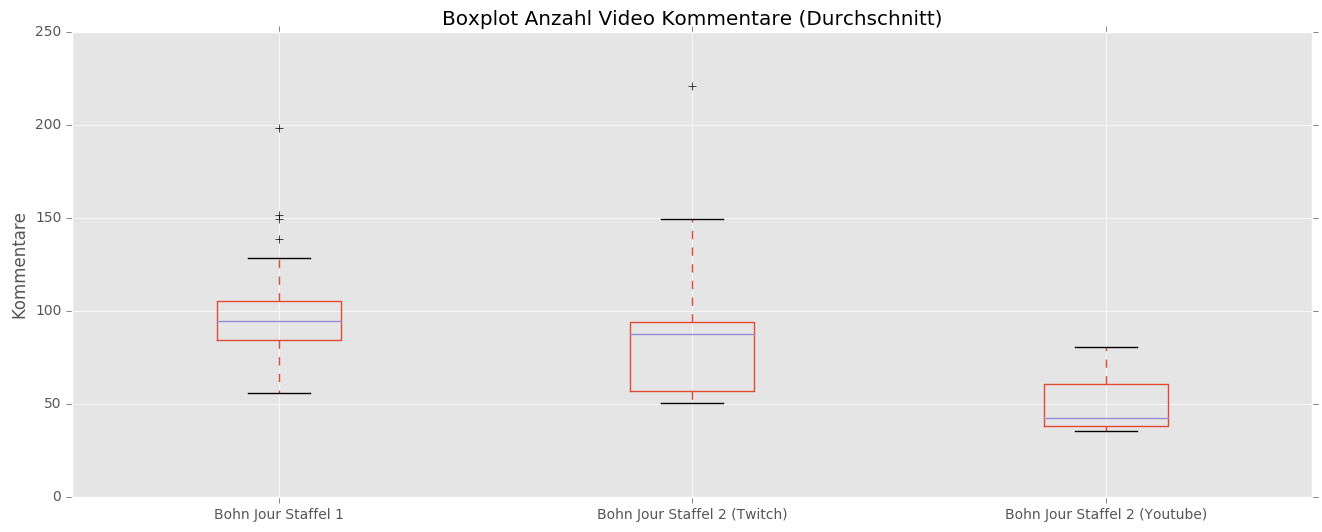

In [35]:
plot = joinedData.plot(kind='box', figsize=(16, 6), title='Boxplot Anzahl Video Kommentare (Durchschnitt)')
plot.set_ylabel('Kommentare')